In [1]:
from generate_data import Data
from evaluate import *
from models import *

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [4]:
%%time
data = Data(layer_size=16, permutation_intervals=2)

c:\Users\franm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


CPU times: total: 812 ms
Wall time: 849 ms


In [5]:
%%time
train, val, test = data.get_splits(['1st_interval'], [])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 900 train | 217 val | 872 test
CPU times: total: 172 ms
Wall time: 170 ms


#### Peek at unshuffled train data

In [6]:
train_original[:10]

[[',..._.._,.___._.', 'w,,_,.,_,__.._.,', 'cr__,._,._,._,__', 'V'],
 [',___._.,_.,,..,_', 'w_.,.,._,_._..,,', ',cr,__,,._._.,,_', 'V'],
 [',_..,__......___', 'w__.____,_,..___', '.,cr_.__._.,..._', 'V'],
 ['_.,,.,....,__._,', 'w,.,.,.___,_,_,_', '.._cr_.___.,,,.,', 'V'],
 [',.._.._,_...,.,_', 'w.__,,_,,_,__..,', '..,_cr_.,.,_.___', 'V'],
 [',,.._.....,,,,,_', 'w_,.._.,...,_.,_', '...__cr..,__,_..', 'V'],
 ['__....,,,._..,,.', 'w.._.,.,__.,.__.', '._..,_cr.,_,__.,', 'V'],
 [',,,__..__.____,.', '_w__,_._,,.__,,.', 'cr...__,..,,__,.', 'V'],
 ['..,._,.__.,__,,_', ',w,_,..__,_,_,..', '_cr,._,__.._,___', 'V'],
 [',.,.,,__,,._.,__', ',w,,_,.__..__,,,', '_,cr_,.,._____.,', 'V']]

In [7]:
train_original[310:320]

[[',_,.__,.,.,..__.', '__.wu,.,...,_._,', 'dr,_,__,,.._,...', 'V'],
 ['_,.,,_._,._,..__', ',._wu.,..,,__...', '_dr._...,..__,..', 'V'],
 ['._____,..,.,....', '_..wu_,_._,,..,_', '__dr_,_,...___..', 'V'],
 ['_.._...,,._____.', '...wu.,.,,_,,___', ',,_dr,.,_,__.,__', 'V'],
 ['.._____._,_..,,_', '__.wu_..,,....,.', '_._,dr,._,_.,,_.', 'V'],
 [',_,,,,_.,__._,,,', '.,.wu.,__.__,.,.', ',__,.dr.__.._,_.', 'V'],
 ['_.._._.,.__...,,', '..,wu..____.,_,.', '__,,_.dr....,.,.', 'V'],
 ['___._._,..__,.,.', '..,.wu..__._,...', 'dr,._.,,__..,,,,', 'V'],
 [',.,,._...._.._._', '.._,wu,..,.,,_._', ',dr_...__..,_,._', 'V'],
 [',.__,,.,_,..,,,.', '.,.,wu_,._,...__', '_.dr__.,,__,,__.', 'V']]

In [8]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 49 | F2-uw 49 | F2-w 56 | F2-noop 56 | 
F3 cr:    F2-wu 49 | F2-uw 49 | F2-w 56 | F2-noop 56 | 
F3 r:    F2-wu 56 | F2-uw 56 | F2-w 64 | F2-noop 64 | 
F3 noop:    F2-wu 56 | F2-uw 56 | F2-w 64 | F2-noop 64 | 

Positive samples count: 401
Total samples count: 900
Positive class ratio: 0.44555555555555554


#### Peek at test data

In [9]:
test_original[:15]

[['__...,_._,,_,,._', '...,,,____,__uw_', '.,,.,,,__,.,._,_', 'V'],
 [',__._,._,,,_,,.,', ',,._._,_.__,..w_', '..,,,,.,.._,,cr.', 'V'],
 ['___,___,,,.,,..,', '._,.,,,uw._...._', '__._.___,cr,_.,_', 'V'],
 ['____,.,.,,_..,_.', '_,_.,...,,w__,,_', '__,._.,__dr,__,.', 'D'],
 ['.,._.__,._.,....', '_..,,,.,,_.,w_..', ',,,.._.,dr,__,_,', 'D'],
 [',,.,,_,,._,,..,_', ',,_,__.,,,___.uw', '_,._,,,..__,__cr', 'V'],
 ['._.._,,_,,,_,_.,', ',,_,,__wu_,_.._.', '..._..,,r.,,.._,', 'R'],
 ['____.__,_,.,,.,,', ',,,_,,.__w,._...', '_.,_,.,_,__._dr,', 'D'],
 [',._.__.,,_....,_', '._.,___,__.,___,', '..,,,_.,.dr,,,..', 'D'],
 ['__.,_,,.,,,..,,,', '.._,..,,,..,_uw.', '_,.,,.,.._.,.,._', 'V'],
 [',,.,......,,_,,.', '_,,,,__,,._...,_', ',...,_.,.cr_,.,_', 'V'],
 ['._._.,_,.,__,._.', '___,...,_,_,wu._', '._....,,,__,.,r_', 'R'],
 ['_,,._.,..,_.,.,,', '.,.._.._w_.__,._', '__._,.,.,_,.._..', 'V'],
 ['_,__._._._,__.,.', ',_.,.,,_._,,w.,,', ',,.._.__..___.cr', 'V'],
 ['__.._.,_____...,', '...,,_._..uw....', ',.,,_

In [10]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 58 | F2-uw 48 | F2-w 54 | F2-noop 58 | 
F3 cr:    F2-wu 58 | F2-uw 53 | F2-w 49 | F2-noop 59 | 
F3 r:    F2-wu 51 | F2-uw 53 | F2-w 52 | F2-noop 57 | 
F3 noop:    F2-wu 56 | F2-uw 53 | F2-w 57 | F2-noop 56 | 

Positive samples count: 373
Total samples count: 872
Positive class ratio: 0.42775229357798167


#### Peek at val data

In [11]:
val_original[:15]

[['._...,._,_..._._', ',....__,_,_...w_', '___.._.,,._,._cr', 'V'],
 ['.,,,,,___._.,___', '__,,.__,_._..wu_', '..,_,,__,.,,r.,.', 'R'],
 ['_._._,___,,_,,..', ',,,__,_____.,,,_', '_.._._,,.._cr..,', 'V'],
 ['_.,_,__,,,__,_.,', '_..._.,._,_,,,_w', '..___._cr,_,___.', 'V'],
 ['....,,.,____..._', ',,__....._,,uw,,', '.,__,.,,.,,dr_._', 'A'],
 [',____.,__.__,_.,', '._,..,._,.,.,.w.', ',_.._.,_,_._.__.', 'V'],
 ['__..,_._....,_,_', ',_.,__.,.,.,.w,,', '_,_,__,.,.,cr_,,', 'V'],
 ['.,,.._.,,,,,,._.', '_,__.,,,,,..uw,.', '_,...,,__.dr,.,.', 'A'],
 ['_.,__.___.__.,__', '__,,,,.,,,__,,uw', '.__,.,_,___,r___', 'R'],
 ['_._.._,__..,,,_,', '.__,,._____,..wu', ',,._._,,___._..,', 'V'],
 [',.._..____,,,,.,', '.,,.,.__,.,_,,,_', '.__,_..__,,._.,r', 'R'],
 [',,,,._,__._,.,_.', '.,._.___...wu,__', '__,,,,__.__,.r.,', 'R'],
 ['.,_._._,,,,_,,_.', ',.,,_,_.._.___,w', ',__,._____._,,.,', 'V'],
 [',.__,,___._,.__.', ',.,.,__..__,,wu.', ',_._.______,,__.', 'V'],
 ['__,.._.,.._..,,_', '_,.,..,,_.._,,.w', '.._,_

In [12]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 6 | F2-uw 16 | F2-w 10 | F2-noop 14 | 
F3 cr:    F2-wu 6 | F2-uw 11 | F2-w 15 | F2-noop 13 | 
F3 r:    F2-wu 13 | F2-uw 11 | F2-w 12 | F2-noop 15 | 
F3 noop:    F2-wu 16 | F2-uw 19 | F2-w 15 | F2-noop 25 | 

Positive samples count: 91
Total samples count: 217
Positive class ratio: 0.41935483870967744


#### Send label arrays to device

In [13]:
from sklearn.preprocessing import LabelEncoder
# Crear un codificador de etiquetas
label_encoder = LabelEncoder()

#input_tensor = input_tensor.requires_grad_()  # Esto habilita el cálculo de gradientes

#cambio de torch.float a torch.long

# Ajustar el codificador a las etiquetas y transformarlas a num enteros
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

y_trainP = y_train

#Un tensor es una estructura de datos similar a matrices o arrays, pero con soporte para operaciones avanzadas en GPU.
# Convertir las etiquetas a tensores de PyTorch
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

#se mueven los datos a la CPU o GPU para que puedan ser procesados por PyTorch durante el entrenamiento o la inferencia

#### Get data in normal format (same as CNN format)

In [14]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [15]:
x_train_normal[0].shape

torch.Size([900, 128])

#### Get data in convolutional format, send to device

In [16]:
x_train_cnn = data.to_conv_format(x_train)
x_val_cnn = data.to_conv_format(x_val)
x_test_cnn = data.to_conv_format(x_test)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [17]:
x_train_cnn[0].shape

torch.Size([900, 128])

#### Get data in LSTM format, send to device

In [18]:
x_train_lstm = data.to_lstm_format(x_train, padding_left_size=2, padding_right_size=0)
x_val_lstm = data.to_lstm_format(x_val, padding_left_size=0, padding_right_size=2)
x_test_lstm = data.to_lstm_format(x_test, padding_left_size=0, padding_right_size=2)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [19]:
x_train_lstm[0].shape

torch.Size([900, 18, 8])

### Define training parameters

In [20]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100
experiment_name="1st_interval"

### Define training procedure for each model

In [21]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    wrong_preds = []
    best_accuracy = 0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./temp/{model_name}_model_TEMP_' + experiment_name)    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break


        model.load_state_dict(torch.load(f'./temp/{model_name}_model_TEMP_' + experiment_name))
        
        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original))
        precisions.append(get_precision(model, x_test, y_test, test_original))
        recalls.append(get_recall(model, x_test, y_test, test_original))
        f1_scores.append(get_f1(precisions[-1], recalls[-1]))
        
        wrong_preds.append((f"Experimento {i}", get_wrong_predictions(model, x_test, y_test, test_original)))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./bestmodels/best_{model_name}_model_' + experiment_name)    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | Current model test accuracy:", accuracies[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test precision:", precisions[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test recall:", recalls[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test f1:", f1_scores[-1]['Overall'])


    
    return accuracies, precisions, recalls, f1_scores, wrong_preds, [train_losses, val_losses, train_accs, val_accs], model
    #return accuracies, precisions, wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [22]:
%%time
cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1, cnn_wrong_preds, cnn_epoch_stats, model = train_models(
    CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.0001, data, 64, 128, 4, -1, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_22764\2177076457.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./temp/{model_name}_mode

1 / 20 models trained | Current model test accuracy: 0.9678899082568807
1 / 20 models trained | Current model test precision: 0.9831857368085606
1 / 20 models trained | Current model test recall: 0.9650976031628367
1 / 20 models trained | Current model test f1: 0.9740577036107692
2 / 20 models trained | Current model test accuracy: 0.963302752293578
2 / 20 models trained | Current model test precision: 0.9747640508148003
2 / 20 models trained | Current model test recall: 0.9567717036683377
2 / 20 models trained | Current model test f1: 0.9656840774581358
3 / 20 models trained | Current model test accuracy: 0.9919724770642202
3 / 20 models trained | Current model test precision: 0.9898852864404452
3 / 20 models trained | Current model test recall: 0.9756455399061033
3 / 20 models trained | Current model test f1: 0.9827138315906696
4 / 20 models trained | Current model test accuracy: 0.9839449541284404
4 / 20 models trained | Current model test precision: 0.9817941176470588
4 / 20 models

In [23]:
%%time
lstm_accuracies, lstm_precision, lstm_recall, lstm_f1, lstm_wrong_preds, lstm_epoch_stats, model = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 32, 8, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_22764\2177076457.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./temp/{model_name}_mode

1 / 20 models trained | Current model test accuracy: 0.8256880733944955
1 / 20 models trained | Current model test precision: 0.6048264039334628
1 / 20 models trained | Current model test recall: 0.6107152720243026
1 / 20 models trained | Current model test f1: 0.607756573240751
2 / 20 models trained | Current model test accuracy: 0.8532110091743119
2 / 20 models trained | Current model test precision: 0.8026536941691943
2 / 20 models trained | Current model test recall: 0.8663959374147356
2 / 20 models trained | Current model test f1: 0.8333076340206483
3 / 20 models trained | Current model test accuracy: 0.926605504587156
3 / 20 models trained | Current model test precision: 0.8933434381328106
3 / 20 models trained | Current model test recall: 0.7890165601155362
3 / 20 models trained | Current model test f1: 0.8379452284781276
4 / 20 models trained | Current model test accuracy: 0.9128440366972477
4 / 20 models trained | Current model test precision: 0.9669565217391305
4 / 20 models 

In [24]:
%%time
deepset_accuracies, deepset_procision, deepset_recall, deepset_f1, deepset_wrong_preds, deepset_epoch_stats, model = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.005, data, 128, 32, 8, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_22764\2177076457.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./temp/{model_name}_mode

1 / 20 models trained | Current model test accuracy: 0.5722477064220184
1 / 20 models trained | Current model test precision: 0.1430619266055046
1 / 20 models trained | Current model test recall: 0.25
1 / 20 models trained | Current model test f1: 0.18198395331874545
2 / 20 models trained | Current model test accuracy: 0.5722477064220184
2 / 20 models trained | Current model test precision: 0.1430619266055046
2 / 20 models trained | Current model test recall: 0.25
2 / 20 models trained | Current model test f1: 0.18198395331874545
3 / 20 models trained | Current model test accuracy: 0.5722477064220184
3 / 20 models trained | Current model test precision: 0.1430619266055046
3 / 20 models trained | Current model test recall: 0.25
3 / 20 models trained | Current model test f1: 0.18198395331874545
4 / 20 models trained | Current model test accuracy: 0.5504587155963303
4 / 20 models trained | Current model test precision: 0.18187558780061802
4 / 20 models trained | Current model test recall:

In [25]:
%%time
deepsetv2_accuracies, deepsetv2_procision, deepsetv2_recall, deepsetv2_f1, deepsetv2_wrong_preds, deepsetv2_epoch_stats, model = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_22764\2177076457.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./temp/{model_name}_mode

1 / 20 models trained | Current model test accuracy: 0.5722477064220184
1 / 20 models trained | Current model test precision: 0.14339080459770115
1 / 20 models trained | Current model test recall: 0.25
1 / 20 models trained | Current model test f1: 0.18224981738495252
2 / 20 models trained | Current model test accuracy: 0.5722477064220184
2 / 20 models trained | Current model test precision: 0.1430619266055046
2 / 20 models trained | Current model test recall: 0.25
2 / 20 models trained | Current model test f1: 0.18198395331874545
3 / 20 models trained | Current model test accuracy: 0.5676605504587156
3 / 20 models trained | Current model test precision: 0.16006944444444443
3 / 20 models trained | Current model test recall: 0.2651199494949495
3 / 20 models trained | Current model test f1: 0.19961741111935988
4 / 20 models trained | Current model test accuracy: 0.5722477064220184
4 / 20 models trained | Current model test precision: 0.1430619266055046
4 / 20 models trained | Current mod

In [26]:
%%time
feedforward_accuracies, feedforward_precision, feedforward_recall, feedforward_f1, feedforward_wrong_preds, feedforward_epoch_stats, model = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_22764\2177076457.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./temp/{model_name}_mode

1 / 20 models trained | Current model test accuracy: 0.5722477064220184
1 / 20 models trained | Current model test precision: 0.1430619266055046
1 / 20 models trained | Current model test recall: 0.25
1 / 20 models trained | Current model test f1: 0.18198395331874545
2 / 20 models trained | Current model test accuracy: 0.5665137614678899
2 / 20 models trained | Current model test precision: 0.19323220536756125
2 / 20 models trained | Current model test recall: 0.24951311072849924
2 / 20 models trained | Current model test f1: 0.21779549958571506
3 / 20 models trained | Current model test accuracy: 0.5722477064220184
3 / 20 models trained | Current model test precision: 0.1430619266055046
3 / 20 models trained | Current model test recall: 0.25
3 / 20 models trained | Current model test f1: 0.18198395331874545
4 / 20 models trained | Current model test accuracy: 0.5665137614678899
4 / 20 models trained | Current model test precision: 0.14293981481481483
4 / 20 models trained | Current mo

# Evaluation

# Evaluacion general de los modelos

In [27]:
import pandas as pd
# Lista de modelos y nombres
model_names = ['CNN', 'LSTM', 'DeepSet', 'DeepSetV2', 'Feedforward']
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
all_precisions = [cnn_precisions, lstm_precision, deepset_procision, deepsetv2_procision, feedforward_precision]
all_recalls = [cnn_recall, lstm_recall, deepset_recall, deepsetv2_recall, feedforward_recall]
all_f1_scores = [cnn_f1, lstm_f1, deepset_f1, deepsetv2_f1, feedforward_f1]

get_summary_df(model_names, all_accuracies, all_precisions, all_recalls, all_f1_scores)

        Modelo  Accuracy  Precision    Recall  F1-score  Precision clase A   
0          CNN  1.000000   1.000000  1.000000  1.000000                1.0  \
1         LSTM  0.954128   0.981447  0.953052  0.967041                1.0   
2      DeepSet  0.572248   0.143062  0.250000  0.181984                0.0   
3    DeepSetV2  0.572248   0.143391  0.250000  0.182250                0.0   
4  Feedforward  0.572248   0.143062  0.250000  0.181984                0.0   

   Recall clase A  Precision clase D  Recall clase D  Precision clase R   
0             1.0                1.0             1.0                1.0  \
1             1.0                1.0             1.0                1.0   
2             0.0                0.0             0.0                0.0   
3             0.0                0.0             0.0                0.0   
4             0.0                0.0             0.0                0.0   

   Recall clase R  Precision clase V  Recall clase V  
0        1.000000        

### Get best 50% performing models

In [28]:
top_half = int(num_experiments / 2)
best_cnn_accs = filter_top_k_accuracies(cnn_accuracies, top_half)
best_lstm_accs = filter_top_k_accuracies(lstm_accuracies, top_half)
best_deepset_accs = filter_top_k_accuracies(deepset_accuracies, top_half)
best_deepsetv2_accs = filter_top_k_accuracies(deepsetv2_accuracies, top_half)
best_feedforward_accs = filter_top_k_accuracies(feedforward_accuracies, top_half)

## Accuracy breakdown by cases for all the models

In [29]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

In [30]:
get_stats_df(all_accuracies, model_names, test_original)

,Overall,cr_noop,cr_uw,cr_w,cr_wu,dr_noop,dr_uw,dr_w,dr_wu,noop_noop,noop_uw,noop_w,noop_wu,r_noop,r_uw,r_w,r_wu
CNN,97.3%,100.0%,100.0%,100.0%,100.0%,98.9%,93.9%,96.7%,94.7%,100.0%,100.0%,100.0%,100.0%,93.7%,92.7%,95.4%,89.2%
LSTM,86.1%,100.0%,99.9%,100.0%,100.0%,87.8%,57.1%,83.1%,52.6%,100.0%,100.0%,100.0%,100.0%,72.8%,71.3%,76.5%,72.0%
DeepSet(like in paper),56.9%,98.6%,99.0%,98.2%,99.7%,0.0%,0.0%,0.0%,98.7%,99.6%,99.8%,99.1%,99.5%,0.4%,0.6%,0.7%,0.7%
DeepSet(sum at start),52.8%,89.7%,89.8%,89.9%,89.8%,0.0%,6.0%,0.1%,89.9%,90.0%,90.0%,90.0%,90.0%,4.5%,3.9%,4.0%,4.2%
Feedforward,57.0%,99.2%,99.2%,99.0%,99.4%,0.2%,0.0%,0.1%,98.8%,99.5%,99.7%,99.6%,99.5%,0.9%,0.4%,0.4%,0.4%
Sample count,872,59,53,49,58,58,48,54,58,56,53,57,56,57,53,52,51


## Accuracy breakdown by cases for top 50% of models

In [31]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['dr', 'r', 'cr', 'noop']

In [32]:
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN,98.7%,100.0%,97.8%,100.0%,96.9%
LSTM,90.6%,100.0%,78.0%,100.0%,84.2%
DeepSet(like in paper),57.2%,100.0%,26.6%,100.0%,0.0%
DeepSet(sum at start),57.2%,100.0%,26.6%,100.0%,0.0%
Feedforward,57.2%,99.9%,26.6%,100.0%,0.0%
Sample count,872,219,218,222,213


In [33]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['r', 'cr', 'noop']

In [34]:
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,dr_noop,dr_uw,dr_w,dr_wu,f3_cr,f3_noop,f3_r
CNN,98.7%,100.0%,96.9%,99.1%,95.0%,100.0%,100.0%,96.9%
LSTM,90.6%,91.4%,62.5%,84.3%,71.7%,100.0%,100.0%,84.2%
DeepSet(like in paper),57.2%,0.0%,0.0%,0.0%,100.0%,100.0%,100.0%,0.0%
DeepSet(sum at start),57.2%,0.0%,0.0%,0.0%,100.0%,100.0%,100.0%,0.0%
Feedforward,57.2%,0.0%,0.0%,0.0%,99.8%,99.9%,100.0%,0.0%
Sample count,872,58,48,54,58,219,222,213


## Accuracies per CNN model

In [35]:
get_stats_per_model(cnn_accuracies, ['CNN #' + str(i) for i in range(len(cnn_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN #0,96.8%,100.0%,99.1%,100.0%,87.8%
CNN #1,96.3%,100.0%,97.2%,100.0%,87.8%
CNN #2,99.2%,100.0%,98.2%,100.0%,98.6%
CNN #3,98.4%,100.0%,96.8%,100.0%,96.7%
CNN #4,99.0%,100.0%,97.2%,100.0%,98.6%
CNN #5,95.4%,100.0%,93.6%,100.0%,87.8%
CNN #6,96.7%,100.0%,93.1%,100.0%,93.4%
CNN #7,95.8%,100.0%,95.0%,100.0%,87.8%
CNN #8,99.1%,100.0%,99.5%,100.0%,96.7%
CNN #9,94.6%,100.0%,90.4%,100.0%,87.8%


In [38]:
get_stats_per_model_multiclass(cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1, "CNN")

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,CNN,0.967890,0.974058,0.983186,0.965098,1.000000,0.982456,1.0,0.950287,1.000000,0.982456,0.877934,1.000000
1,CNN,0.963303,0.965684,0.974764,0.956772,1.000000,0.949153,1.0,0.949904,1.000000,0.949153,0.877934,1.000000
2,CNN,0.991972,0.982714,0.989885,0.975646,1.000000,0.965517,1.0,0.994024,0.916667,1.000000,0.985915,1.000000
3,CNN,0.983945,0.977813,0.981794,0.973864,1.000000,0.941176,1.0,0.986000,0.979167,0.949153,0.967136,1.000000
4,CNN,0.989679,0.984770,0.985776,0.983767,1.000000,0.949153,1.0,0.993952,1.000000,0.949153,0.985915,1.000000
5,CNN,0.954128,0.962069,0.981447,0.943442,1.000000,1.000000,1.0,0.925788,0.895833,1.000000,0.877934,1.000000
6,CNN,0.966743,0.960885,0.973667,0.948435,0.977273,0.963636,1.0,0.953757,0.895833,0.963636,0.934272,1.000000
7,CNN,0.957569,0.953759,0.972389,0.935830,1.000000,0.948718,1.0,0.940840,0.916667,0.948718,0.877934,1.000000
8,CNN,0.990826,0.991293,0.996055,0.986576,1.000000,1.000000,1.0,0.984221,0.979167,1.000000,0.967136,1.000000
9,CNN,0.946101,0.949228,0.974380,0.925342,1.000000,0.980392,1.0,0.917127,0.833333,0.990099,0.877934,1.000000


## Accuracies per LSTM model

In [39]:
get_stats_per_model(best_lstm_accs, ['LSTM #' + str(i) for i in range(len(best_lstm_accs))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
LSTM #0,95.4%,100.0%,100.0%,100.0%,81.2%
LSTM #1,93.8%,100.0%,88.5%,100.0%,86.4%
LSTM #2,92.7%,100.0%,71.6%,100.0%,99.1%
LSTM #3,91.3%,100.0%,97.2%,100.0%,67.1%
LSTM #4,89.8%,99.5%,65.1%,100.0%,94.4%
LSTM #5,89.3%,100.0%,87.2%,100.0%,69.5%
LSTM #6,89.0%,100.0%,81.7%,100.0%,73.7%
LSTM #7,88.5%,100.0%,65.6%,100.0%,88.3%
LSTM #8,88.4%,100.0%,67.9%,100.0%,85.4%
LSTM #9,88.1%,100.0%,55.5%,100.0%,96.7%


In [43]:
get_stats_per_model_multiclass(lstm_accuracies, lstm_precision, lstm_recall, lstm_f1, "LSTM")

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,LSTM,0.825688,0.607757,0.604826,0.610715,0.000000,0.513761,1.000000,0.905544,0.000000,0.658824,0.784038,1.000000
1,LSTM,0.853211,0.833308,0.802654,0.866396,0.449438,1.000000,0.873626,0.887550,0.833333,1.000000,0.746479,0.885772
2,LSTM,0.926606,0.837945,0.893343,0.789017,0.750000,1.000000,0.890295,0.933078,0.187500,1.000000,0.990610,0.977956
3,LSTM,0.912844,0.925031,0.966957,0.886590,1.000000,1.000000,1.000000,0.867826,0.875000,1.000000,0.671362,1.000000
4,LSTM,0.880734,0.853754,0.807887,0.905142,0.471429,1.000000,0.774436,0.985685,0.687500,1.000000,0.967136,0.965932
5,LSTM,0.880734,0.778969,0.809059,0.751037,0.655172,0.664671,0.988827,0.927565,0.395833,0.798561,0.830986,0.978769
6,LSTM,0.829128,0.822912,0.815947,0.829997,0.444444,1.000000,1.000000,0.819343,0.833333,1.000000,0.586854,0.899800
7,LSTM,0.873853,0.906504,0.954844,0.862823,1.000000,1.000000,1.000000,0.819376,0.958333,1.000000,0.492958,1.000000
8,LSTM,0.885321,0.849650,0.824220,0.876699,0.523077,1.000000,0.843049,0.930754,0.708333,1.000000,0.882629,0.915832
9,LSTM,0.884174,0.769658,0.773347,0.766004,0.452381,0.704403,1.000000,0.936605,0.395833,0.861538,0.854460,0.952183


## Accuracies per DeepSets V1 model

In [44]:
get_stats_per_model(deepset_accuracies, ['DeepSet(like in paper) #' + str(i) for i in range(len(deepset_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(like in paper) #0,57.2%,100.0%,26.6%,100.0%,0.0%
DeepSet(like in paper) #1,57.2%,100.0%,26.6%,100.0%,0.0%
DeepSet(like in paper) #2,57.2%,100.0%,26.6%,100.0%,0.0%
DeepSet(like in paper) #3,55.0%,94.5%,23.9%,96.4%,3.3%
DeepSet(like in paper) #4,56.8%,97.7%,26.1%,100.0%,0.9%
DeepSet(like in paper) #5,57.2%,100.0%,26.6%,100.0%,0.0%
DeepSet(like in paper) #6,56.7%,99.1%,26.1%,99.1%,0.0%
DeepSet(like in paper) #7,57.2%,100.0%,26.6%,100.0%,0.0%
DeepSet(like in paper) #8,57.2%,100.0%,26.6%,100.0%,0.0%
DeepSet(like in paper) #9,57.2%,100.0%,26.6%,100.0%,0.0%


In [47]:
get_stats_per_model_multiclass(deepset_accuracies, deepset_procision, deepset_recall, deepset_f1, "DEEPSET")

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,DEEPSET,0.572248,0.181984,0.143062,0.250000,0.0,0.0,0.000000,0.572248,0.0,0.0,0.000000,1.000000
1,DEEPSET,0.572248,0.181984,0.143062,0.250000,0.0,0.0,0.000000,0.572248,0.0,0.0,0.000000,1.000000
2,DEEPSET,0.572248,0.181984,0.143062,0.250000,0.0,0.0,0.000000,0.572248,0.0,0.0,0.000000,1.000000
3,DEEPSET,0.550459,0.208839,0.181876,0.245190,0.0,0.0,0.155556,0.571947,0.0,0.0,0.032864,0.947896
4,DEEPSET,0.567661,0.214760,0.188602,0.249341,0.0,0.0,0.181818,0.572590,0.0,0.0,0.009390,0.987976
5,DEEPSET,0.572248,0.181984,0.143062,0.250000,0.0,0.0,0.000000,0.572248,0.0,0.0,0.000000,1.000000
6,DEEPSET,0.566514,0.180820,0.142445,0.247495,0.0,0.0,0.000000,0.569781,0.0,0.0,0.000000,0.989980
7,DEEPSET,0.572248,0.181984,0.143062,0.250000,0.0,0.0,0.000000,0.572248,0.0,0.0,0.000000,1.000000
8,DEEPSET,0.572248,0.181984,0.143062,0.250000,0.0,0.0,0.000000,0.572248,0.0,0.0,0.000000,1.000000
9,DEEPSET,0.572248,0.181984,0.143062,0.250000,0.0,0.0,0.000000,0.572248,0.0,0.0,0.000000,1.000000


## Accuracies per DeepSets V2 model

In [48]:
get_stats_per_model(deepsetv2_accuracies, ['DeepSet(sum at start) #' + str(i) for i in range(len(deepsetv2_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(sum at start) #0,57.2%,100.0%,26.6%,100.0%,0.0%
DeepSet(sum at start) #1,57.2%,100.0%,26.6%,100.0%,0.0%
DeepSet(sum at start) #2,56.8%,98.2%,26.6%,100.0%,0.0%
DeepSet(sum at start) #3,57.2%,100.0%,26.6%,100.0%,0.0%
DeepSet(sum at start) #4,57.2%,100.0%,26.6%,100.0%,0.0%
DeepSet(sum at start) #5,57.2%,100.0%,26.6%,100.0%,0.0%
DeepSet(sum at start) #6,57.2%,100.0%,26.6%,100.0%,0.0%
DeepSet(sum at start) #7,57.2%,100.0%,26.6%,100.0%,0.0%
DeepSet(sum at start) #8,57.2%,100.0%,26.6%,100.0%,0.0%
DeepSet(sum at start) #9,57.2%,100.0%,26.6%,100.0%,0.0%


In [53]:
get_stats_per_model_multiclass(deepsetv2_accuracies, deepsetv2_procision, deepsetv2_recall, deepsetv2_f1, "DEEPSETv2")

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,DEEPSETv2,0.572248,0.182250,0.143391,0.250000,0.000000,0.0000,0.000000,0.573563,0.000000,0.0000,0.000000,1.000000
1,DEEPSETv2,0.572248,0.181984,0.143062,0.250000,0.000000,0.0000,0.000000,0.572248,0.000000,0.0000,0.000000,1.000000
2,DEEPSETv2,0.567661,0.199617,0.160069,0.265120,0.000000,0.0625,0.000000,0.577778,0.000000,0.0625,0.000000,0.997980
3,DEEPSETv2,0.572248,0.181984,0.143062,0.250000,0.000000,0.0000,0.000000,0.572248,0.000000,0.0000,0.000000,1.000000
4,DEEPSETv2,0.572248,0.181984,0.143062,0.250000,0.000000,0.0000,0.000000,0.572248,0.000000,0.0000,0.000000,1.000000
5,DEEPSETv2,0.572248,0.181984,0.143062,0.250000,0.000000,0.0000,0.000000,0.572248,0.000000,0.0000,0.000000,1.000000
6,DEEPSETv2,0.572248,0.181984,0.143062,0.250000,0.000000,0.0000,0.000000,0.572248,0.000000,0.0000,0.000000,1.000000
7,DEEPSETv2,0.572248,0.181984,0.143062,0.250000,0.000000,0.0000,0.000000,0.572248,0.000000,0.0000,0.000000,1.000000
8,DEEPSETv2,0.572248,0.181984,0.143062,0.250000,0.000000,0.0000,0.000000,0.572248,0.000000,0.0000,0.000000,1.000000
9,DEEPSETv2,0.572248,0.181984,0.143062,0.250000,0.000000,0.0000,0.000000,0.572248,0.000000,0.0000,0.000000,1.000000


## Accuracies per FeedForward model

In [54]:
get_stats_per_model(feedforward_accuracies, ['Feedforward #' + str(i) for i in range(len(feedforward_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
Feedforward #0,57.2%,100.0%,26.6%,100.0%,0.0%
Feedforward #1,56.7%,98.2%,25.7%,99.1%,1.4%
Feedforward #2,57.2%,100.0%,26.6%,100.0%,0.0%
Feedforward #3,56.7%,98.2%,26.6%,99.5%,0.0%
Feedforward #4,56.8%,99.1%,25.7%,100.0%,0.0%
Feedforward #5,56.8%,97.3%,27.1%,99.5%,0.9%
Feedforward #6,57.2%,100.0%,26.6%,100.0%,0.0%
Feedforward #7,56.9%,98.6%,25.7%,100.0%,0.9%
Feedforward #8,57.1%,99.1%,26.6%,100.0%,0.5%
Feedforward #9,56.5%,96.8%,26.1%,99.1%,1.9%


In [59]:
get_stats_per_model_multiclass(feedforward_accuracies, feedforward_precision, feedforward_recall, feedforward_f1, "FEEDFORWARD")

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,FEEDFORWARD,0.572248,0.181984,0.143062,0.250000,0.0,0.0,0.000000,0.572248,0.0,0.0,0.000000,1.000000
1,FEEDFORWARD,0.566514,0.217795,0.193232,0.249513,0.0,0.0,0.200000,0.572929,0.0,0.0,0.014085,0.983968
2,FEEDFORWARD,0.572248,0.181984,0.143062,0.250000,0.0,0.0,0.000000,0.572248,0.0,0.0,0.000000,1.000000
3,FEEDFORWARD,0.566514,0.181218,0.142940,0.247495,0.0,0.0,0.000000,0.571759,0.0,0.0,0.000000,0.989980
4,FEEDFORWARD,0.567661,0.181852,0.143561,0.247996,0.0,0.0,0.000000,0.574246,0.0,0.0,0.000000,0.991984
5,FEEDFORWARD,0.567661,0.346850,0.323496,0.373837,0.0,0.5,0.222222,0.571762,0.0,0.5,0.009434,0.985915
6,FEEDFORWARD,0.572248,0.181984,0.143062,0.250000,0.0,0.0,0.000000,0.572248,0.0,0.0,0.000000,1.000000
7,FEEDFORWARD,0.568807,0.217946,0.193271,0.249842,0.0,0.0,0.200000,0.573086,0.0,0.0,0.009390,0.989980
8,FEEDFORWARD,0.571101,0.237645,0.226314,0.250172,0.0,0.0,0.333333,0.571922,0.0,0.0,0.004695,0.995992
9,FEEDFORWARD,0.565367,0.223207,0.201806,0.249685,0.0,0.0,0.235294,0.571930,0.0,0.0,0.018779,0.979960


# Training evolution

### CNN

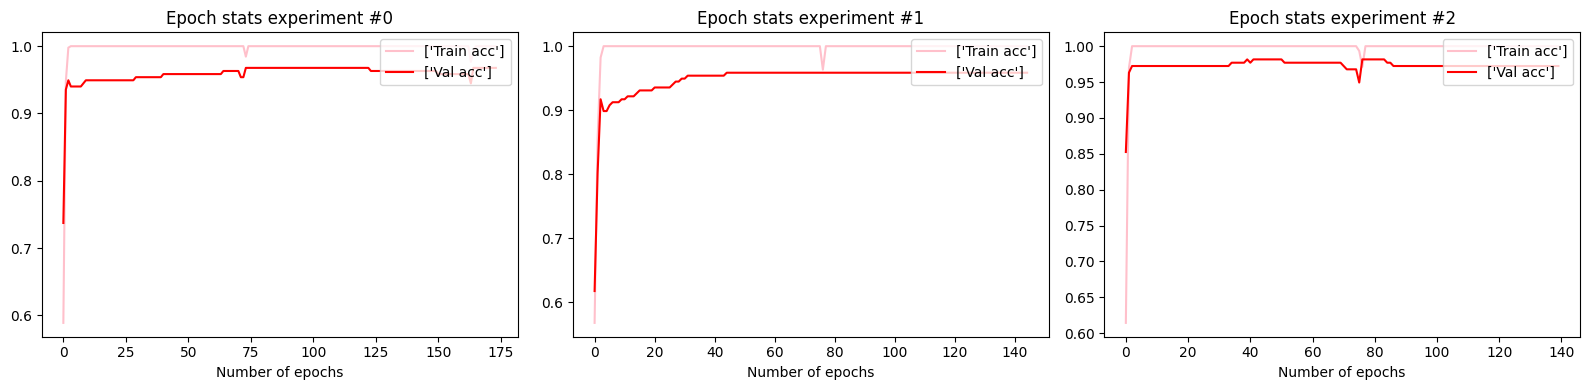

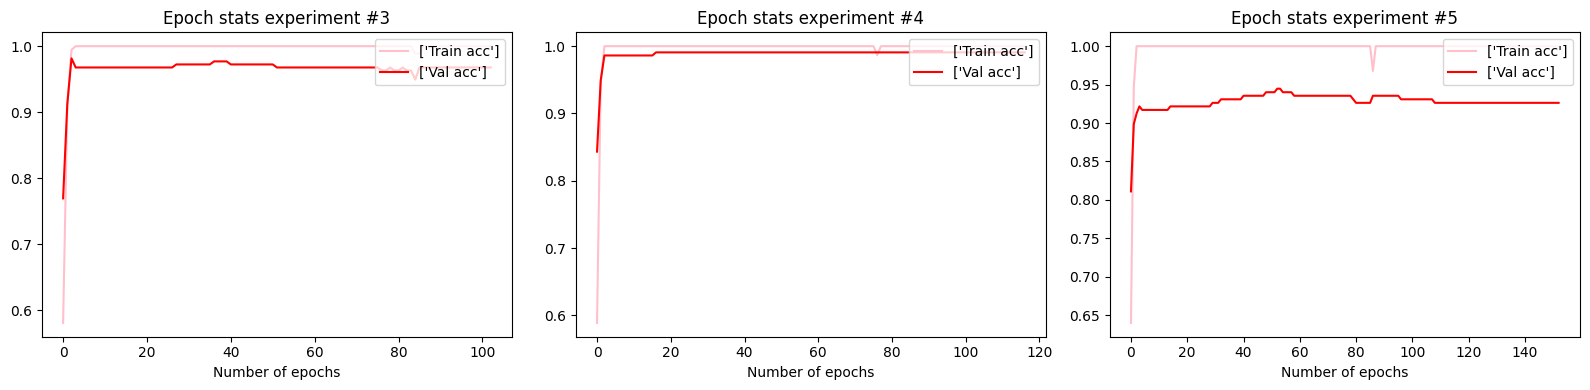

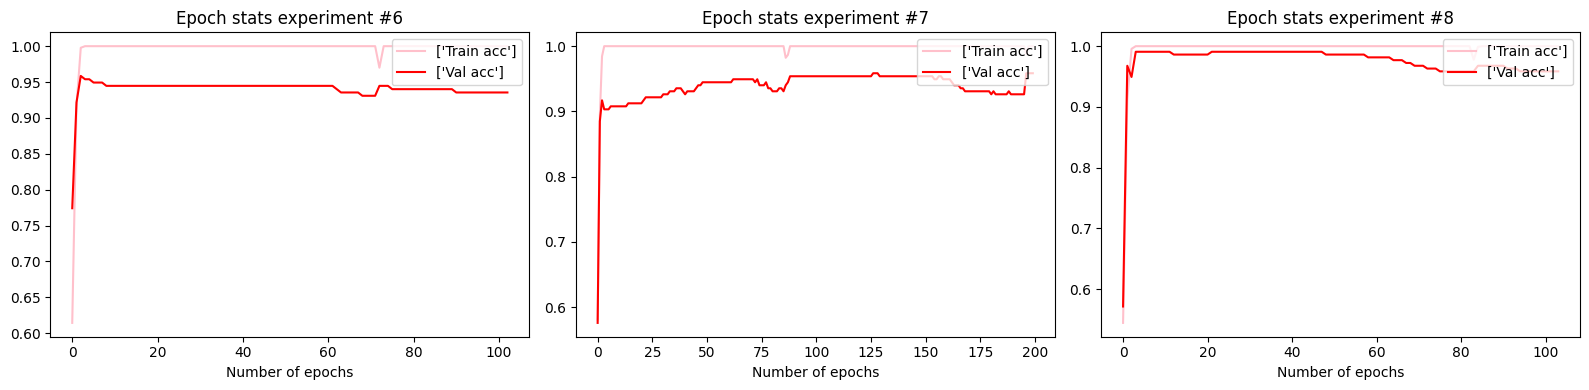

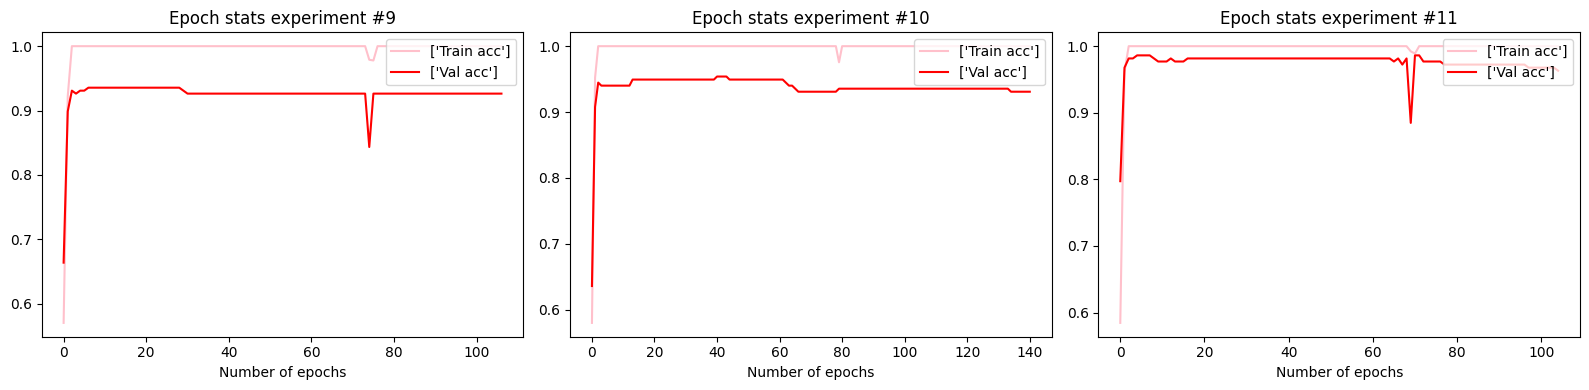

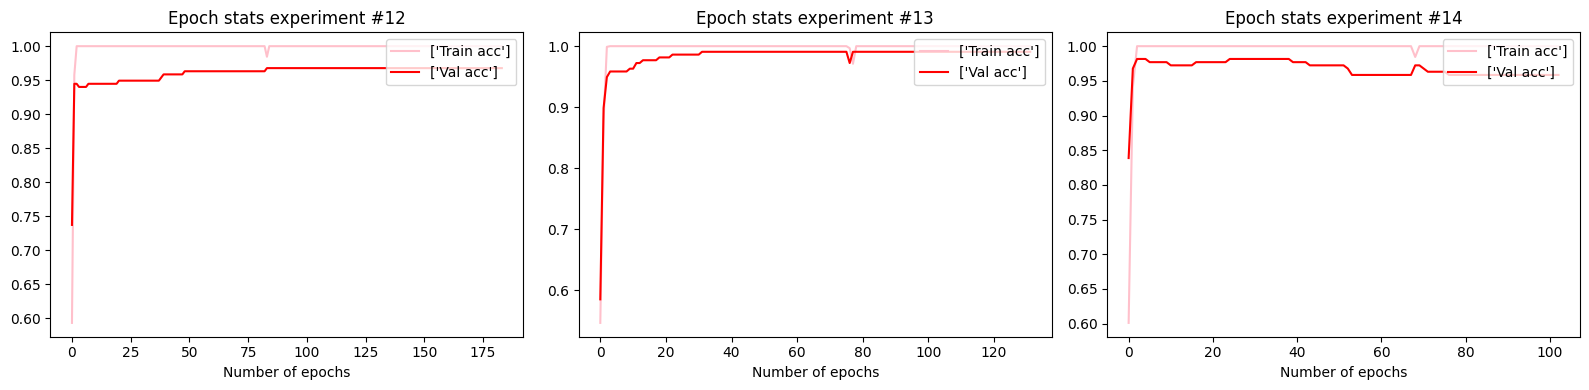

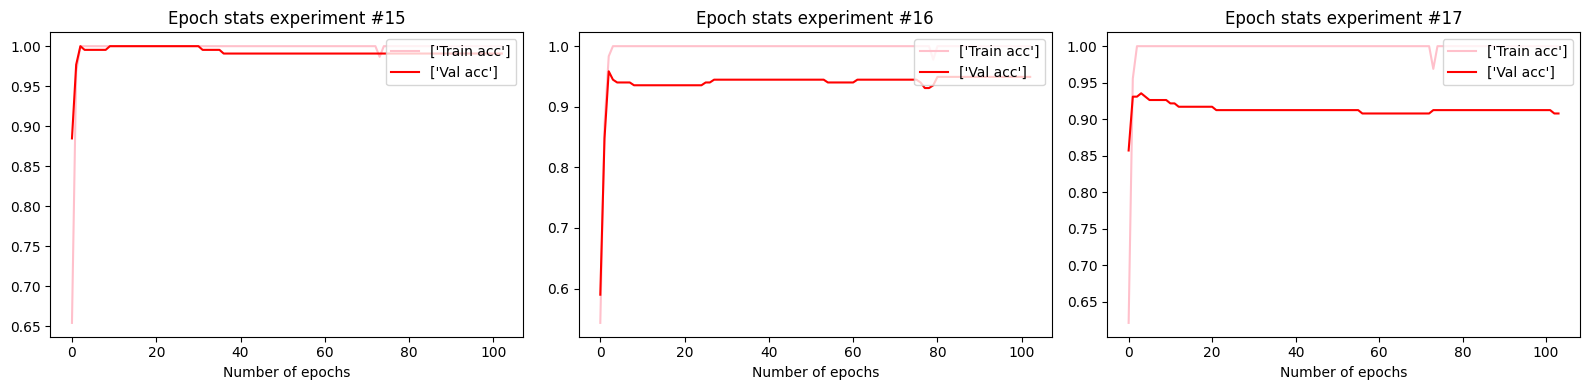

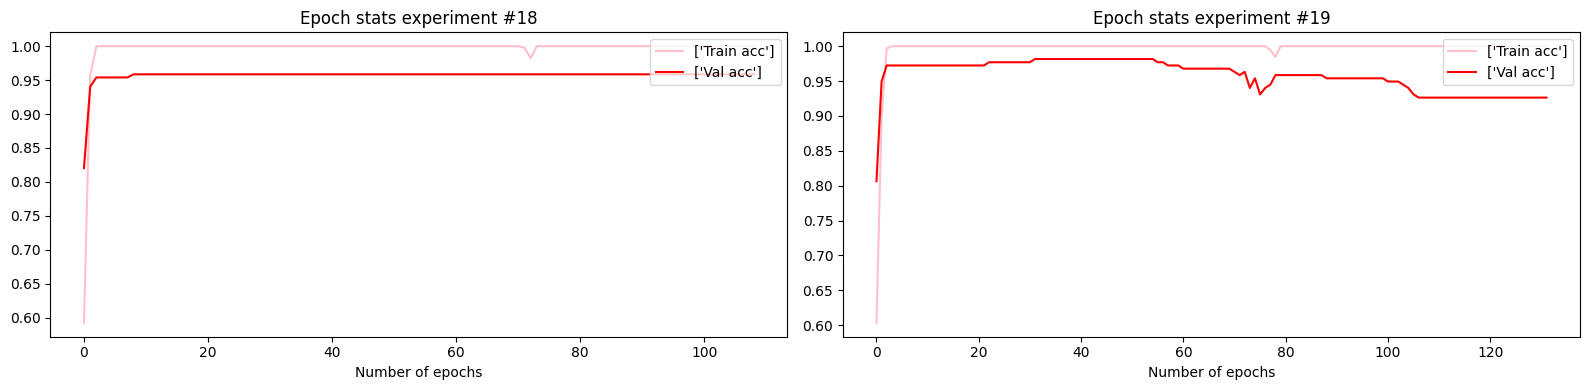

In [60]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

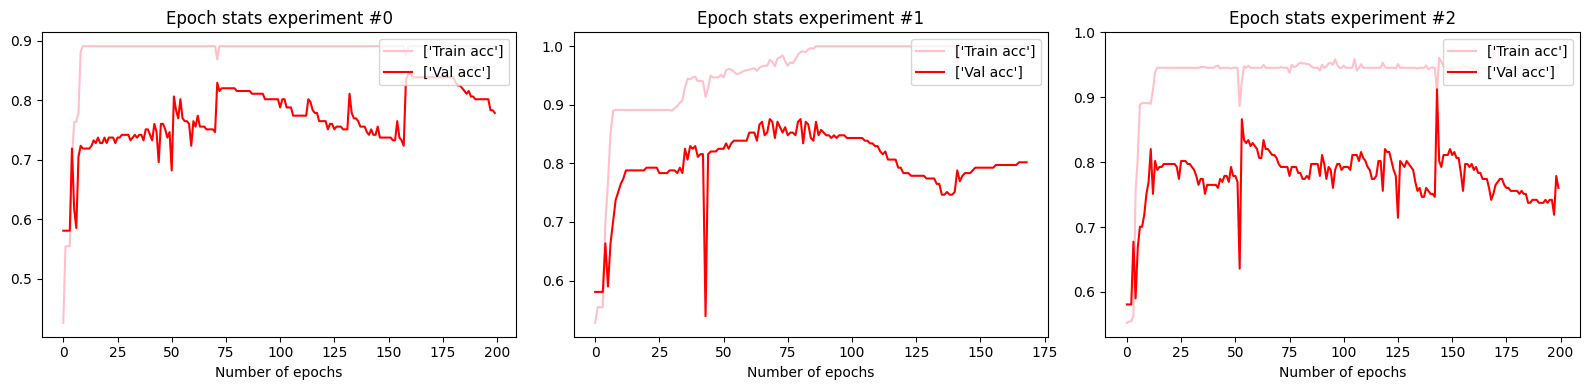

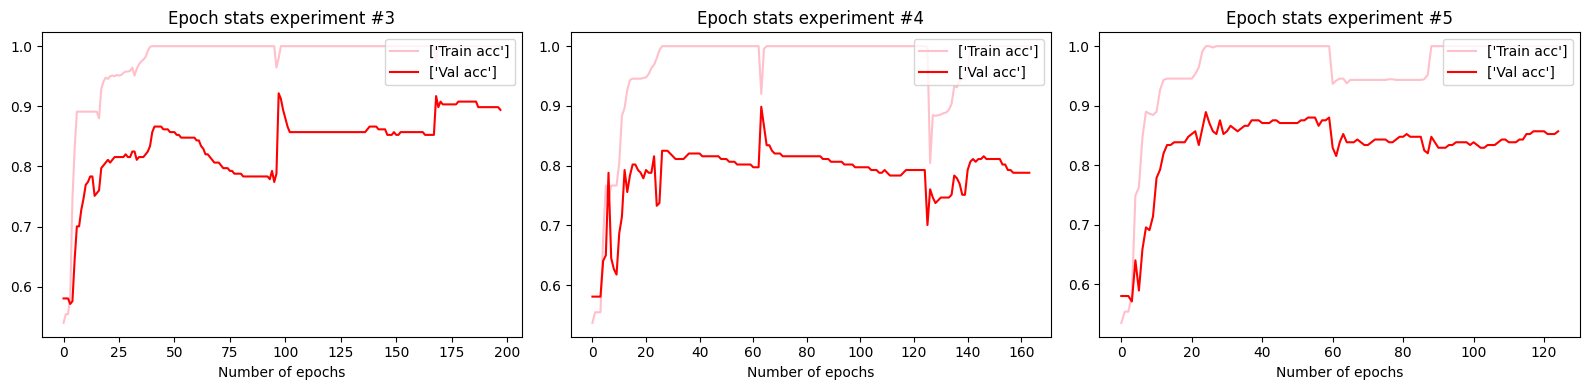

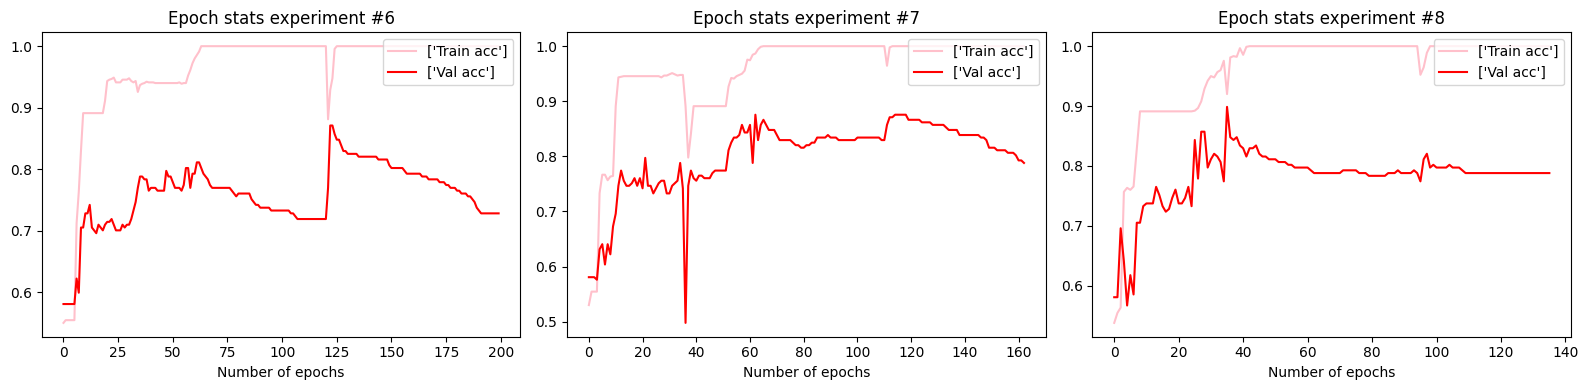

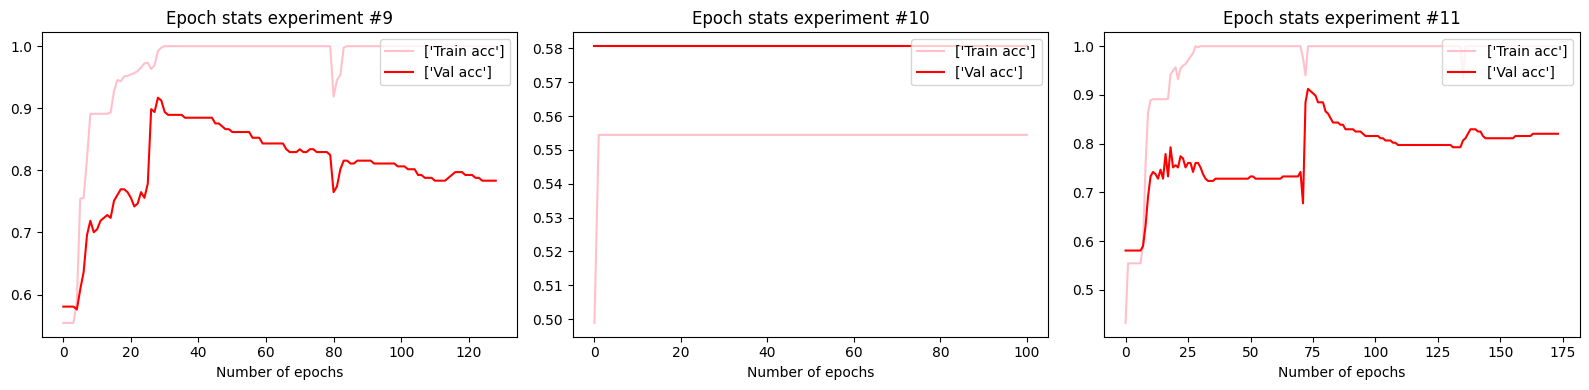

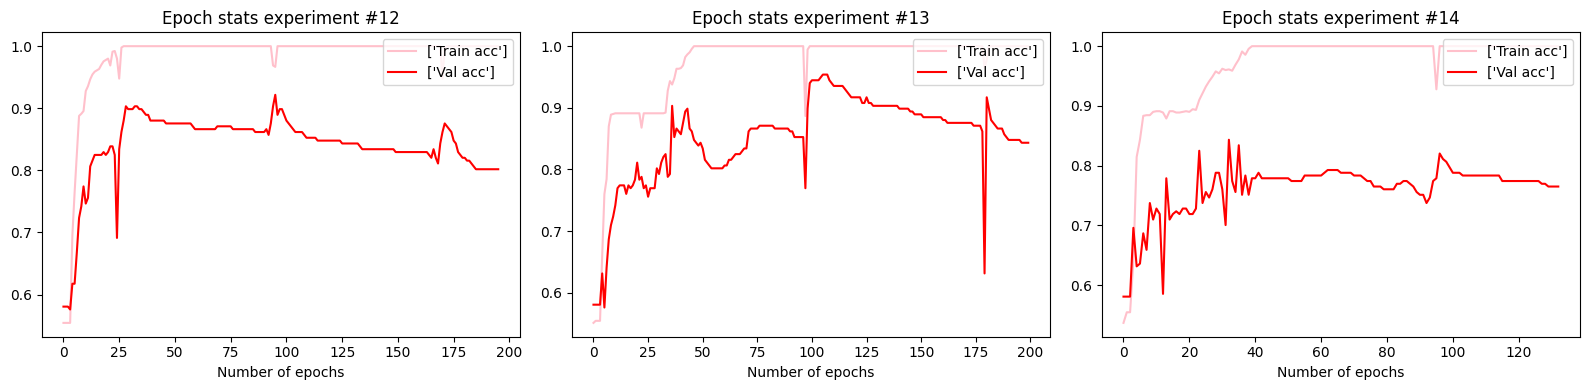

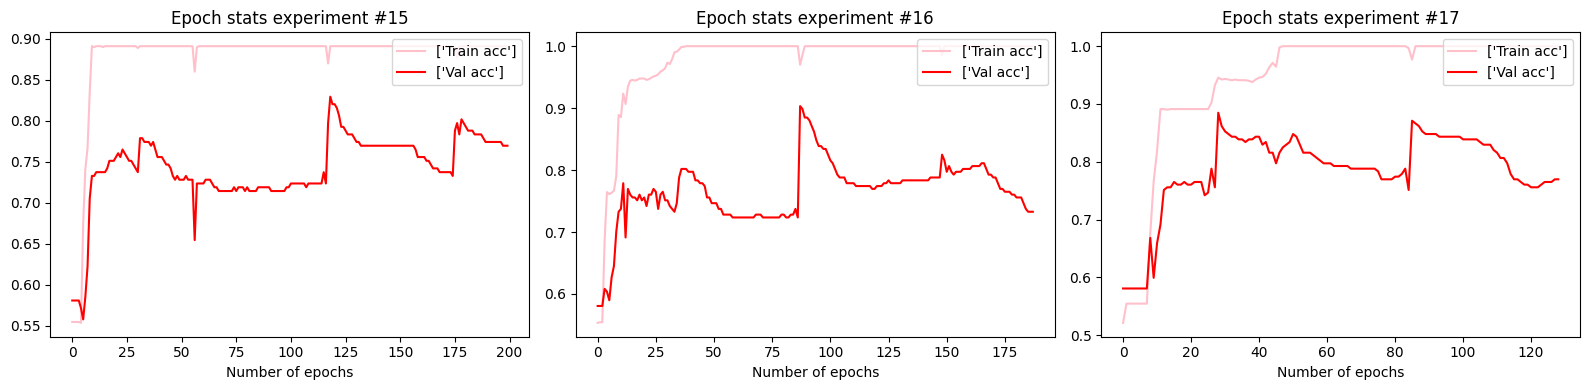

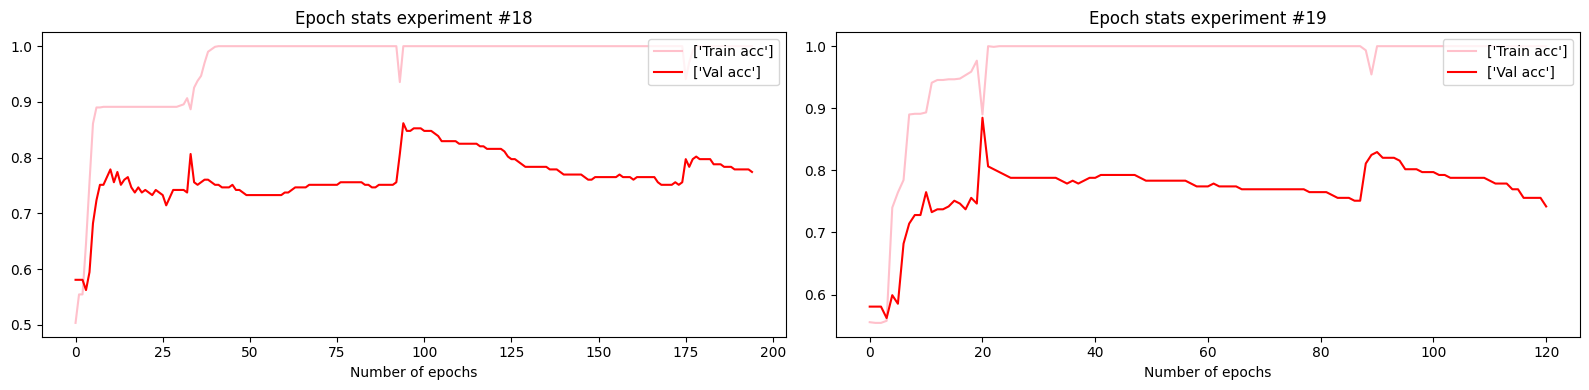

In [61]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

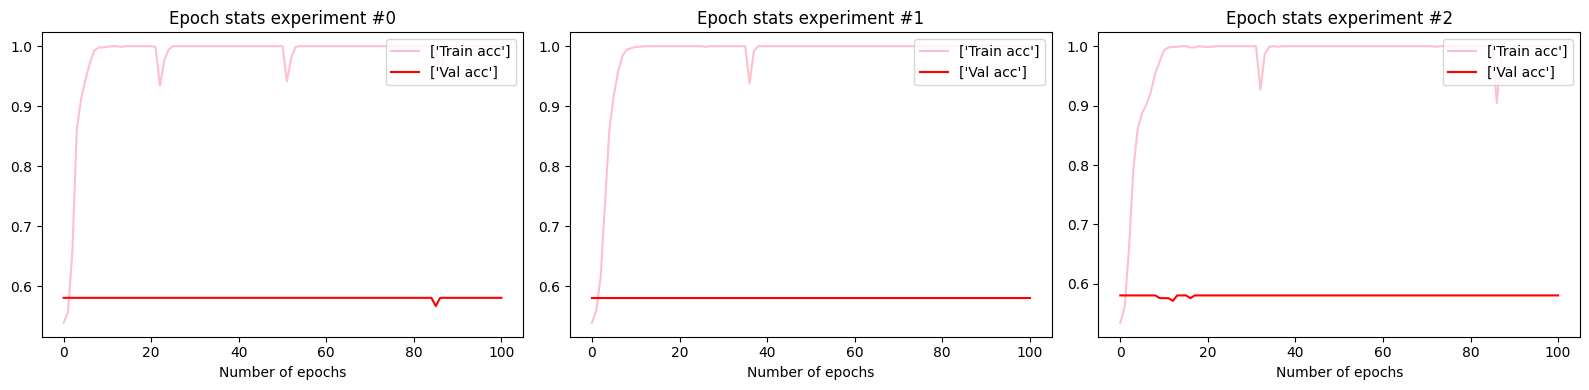

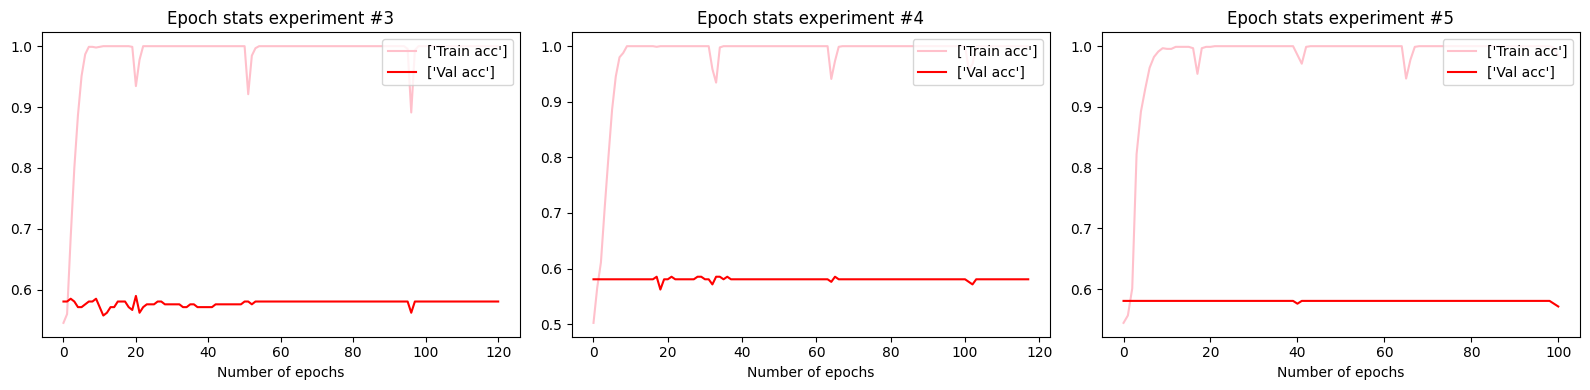

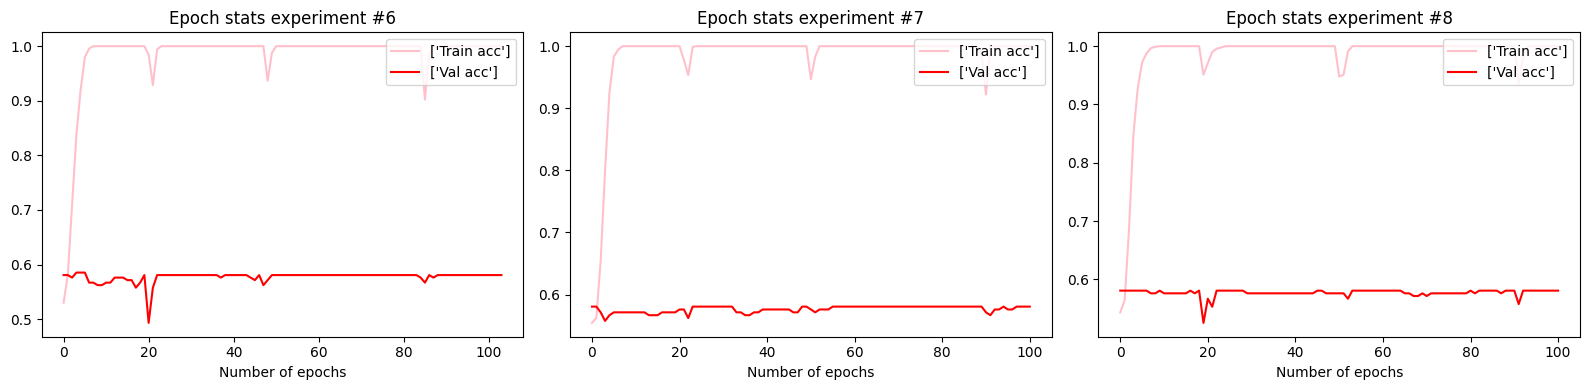

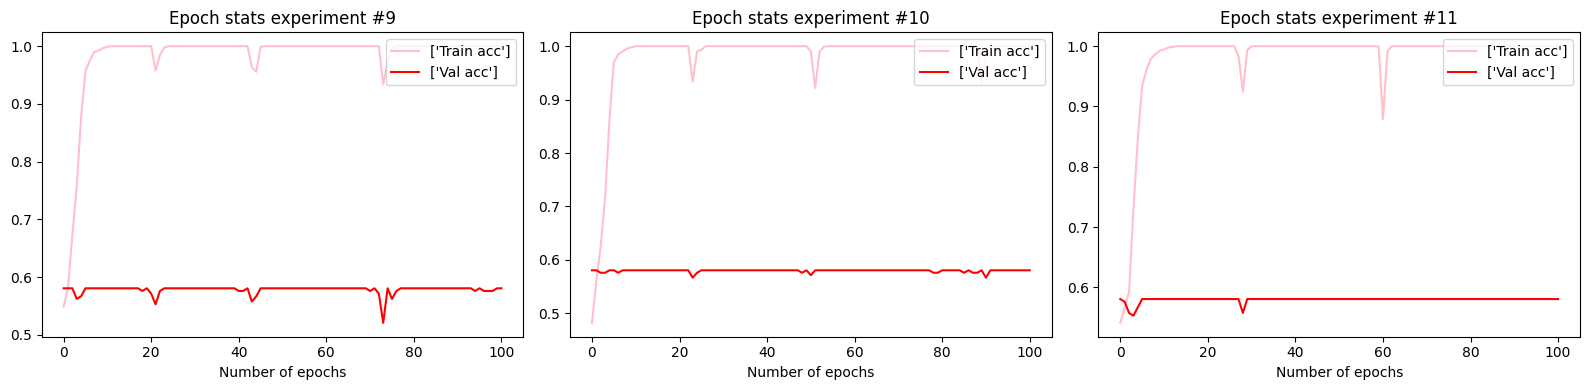

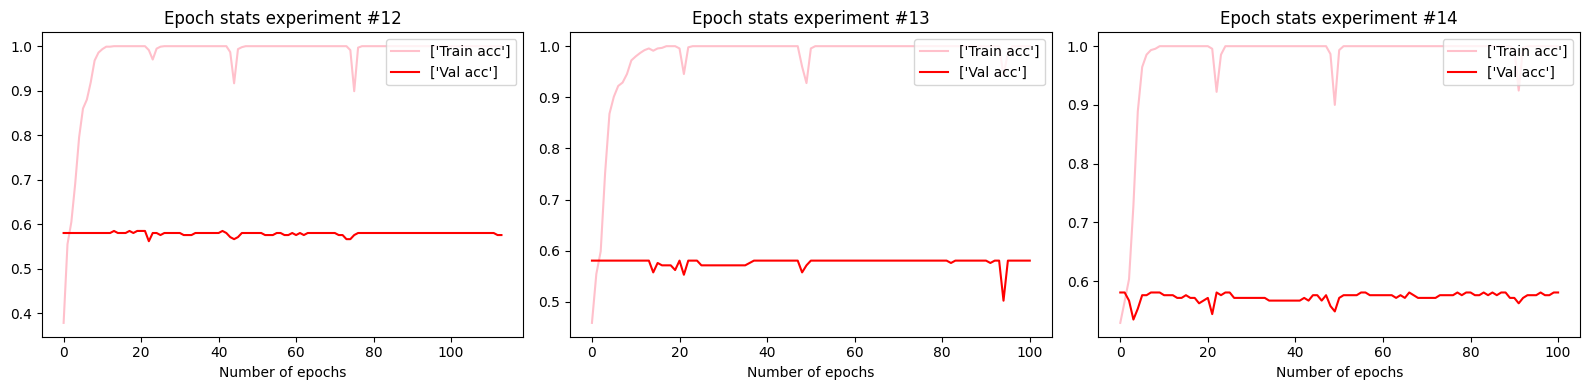

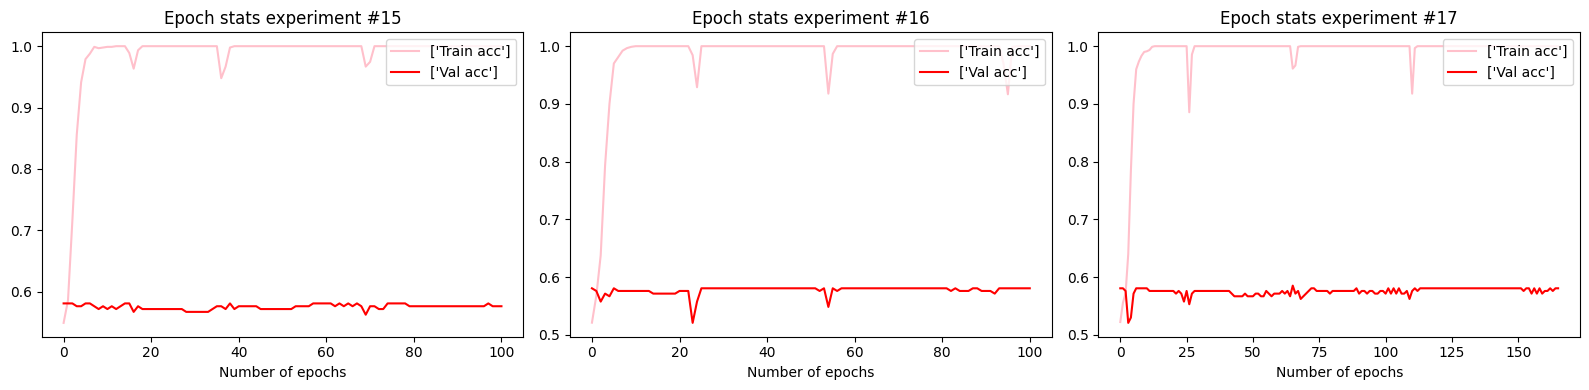

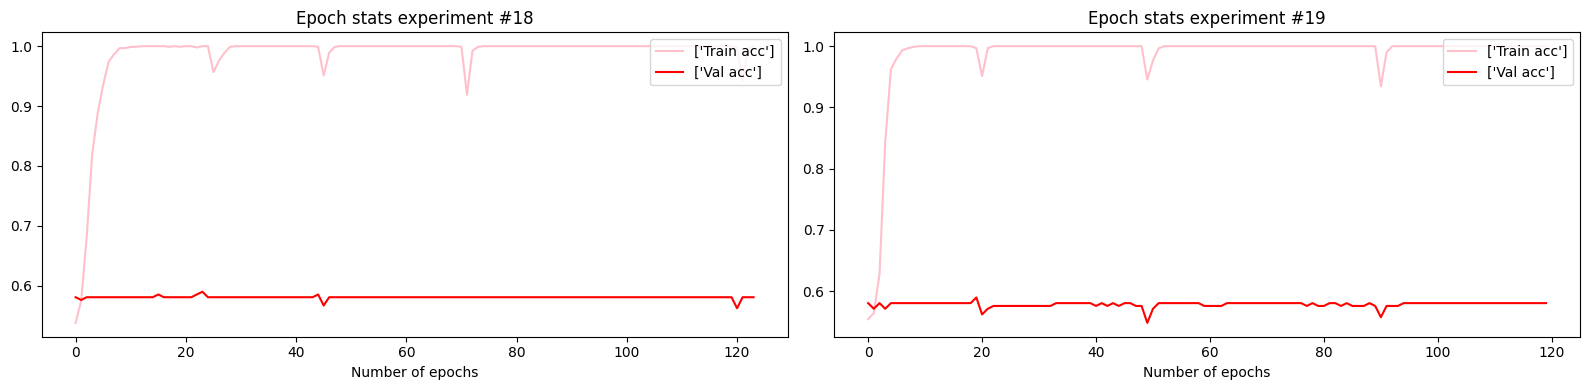

In [62]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

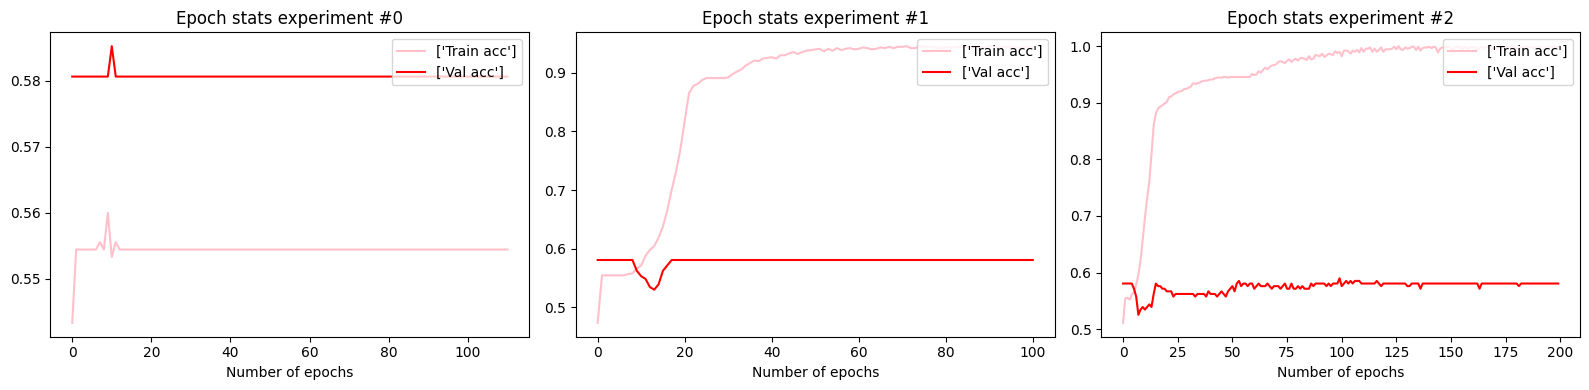

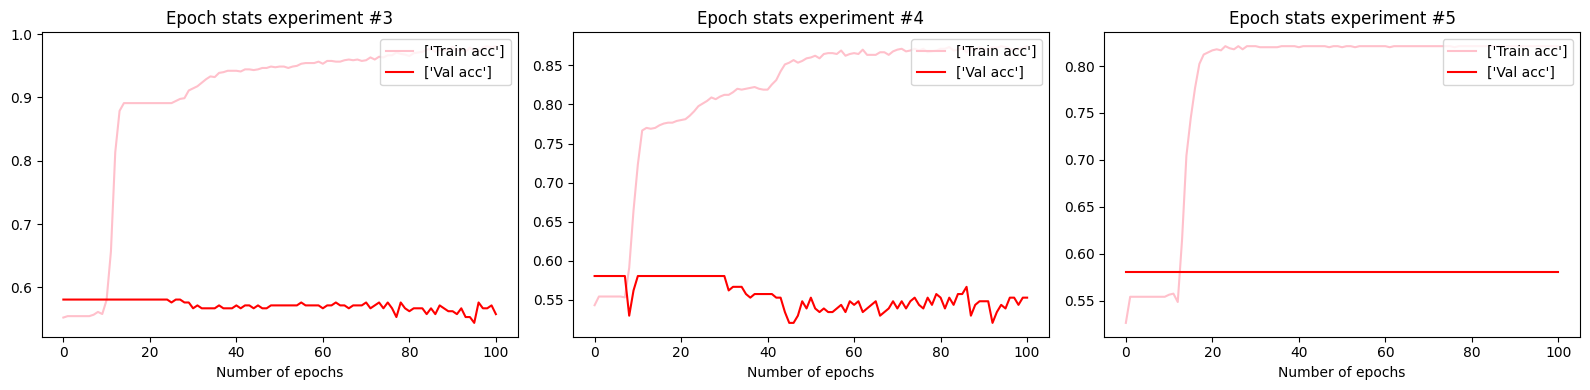

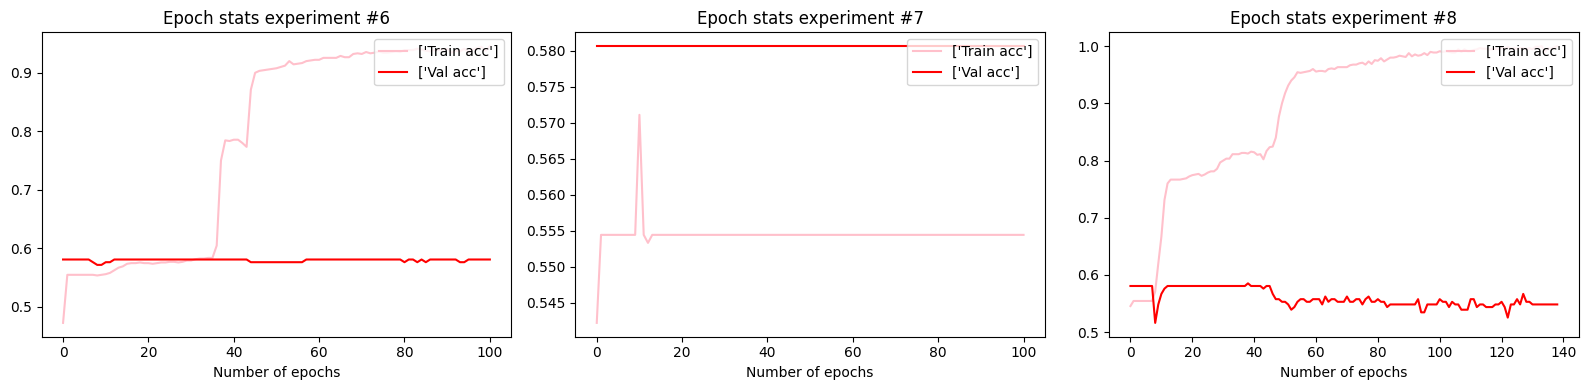

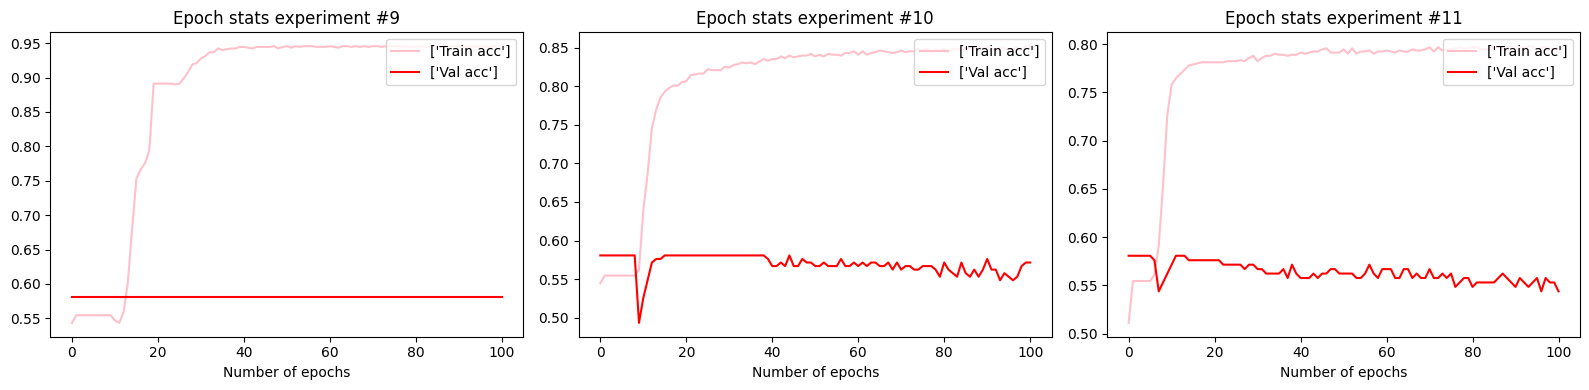

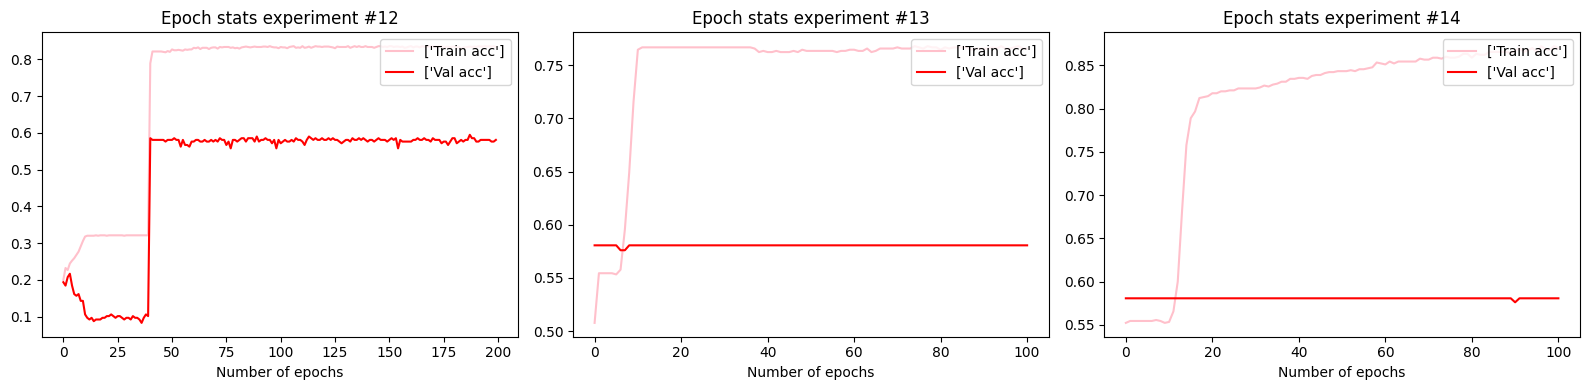

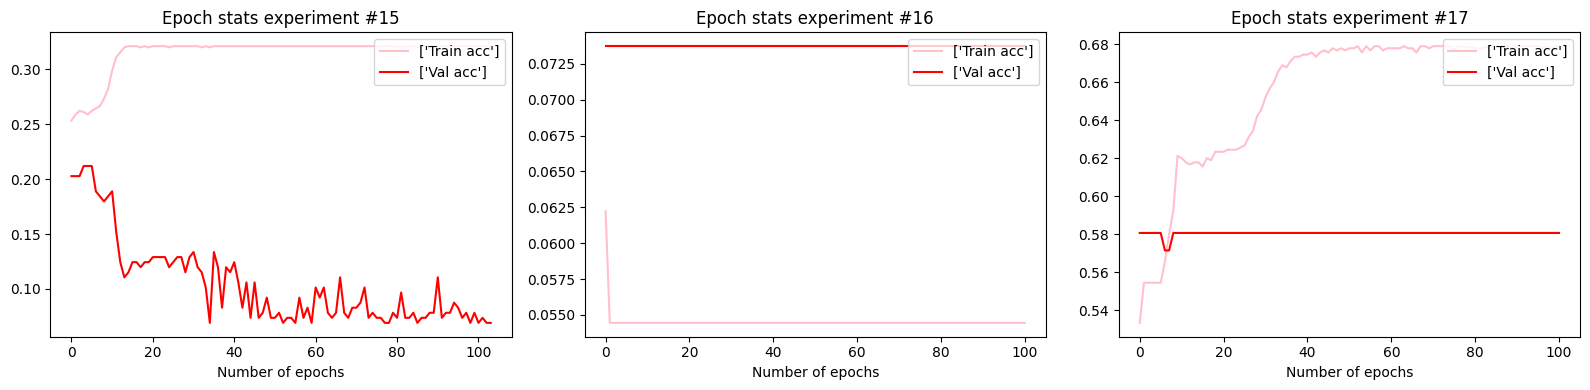

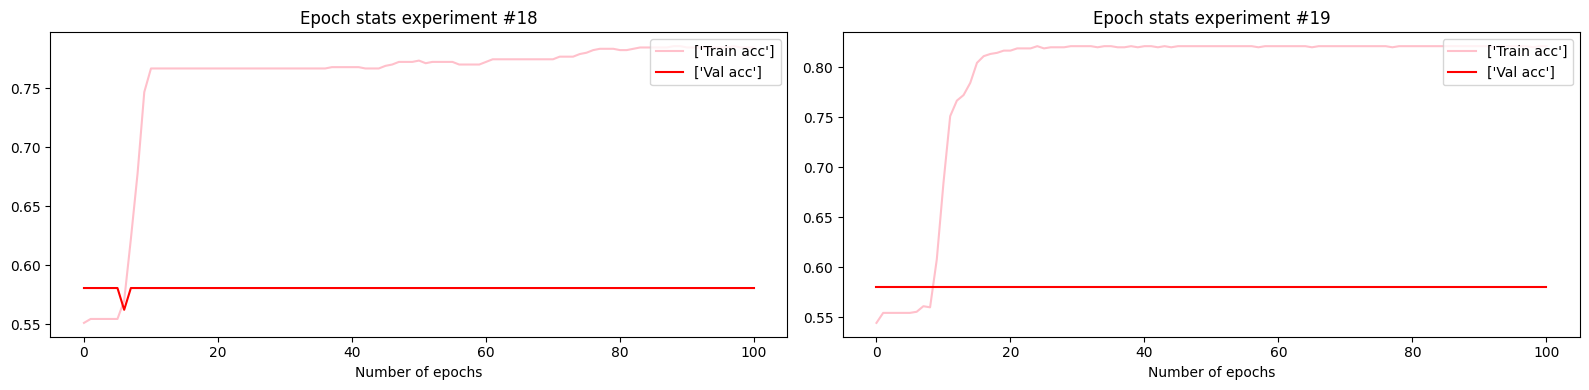

In [63]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

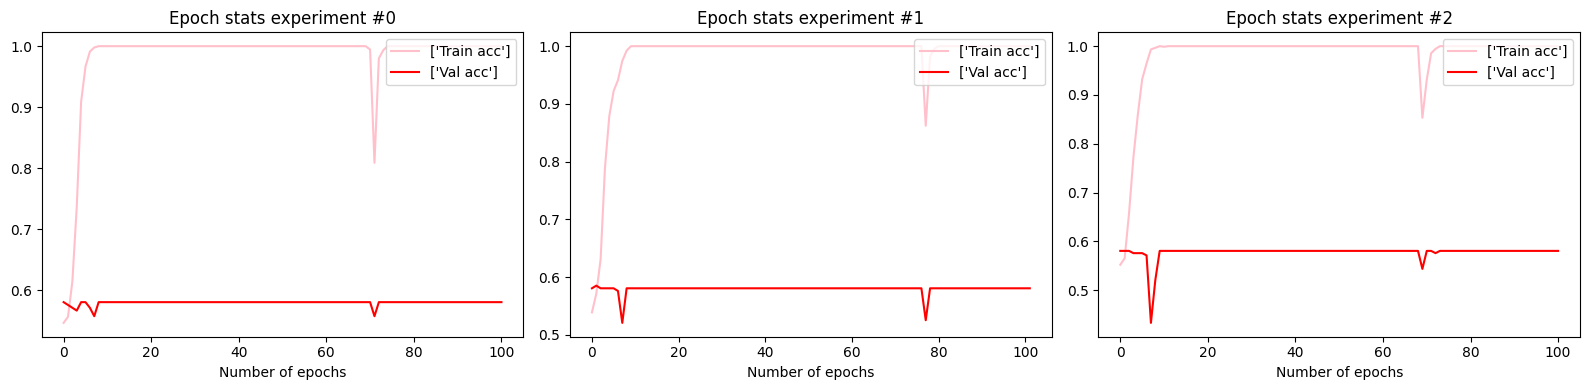

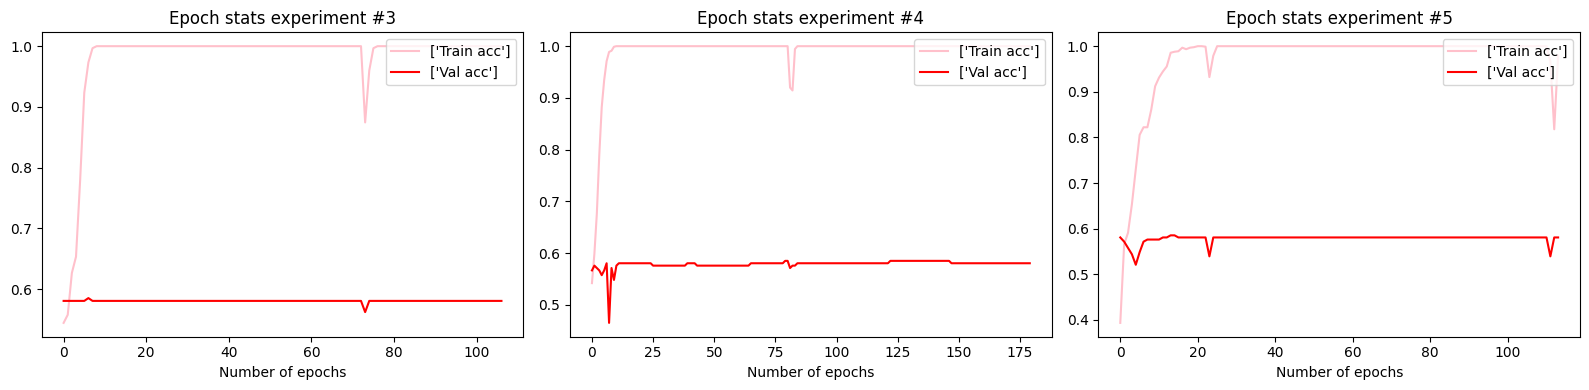

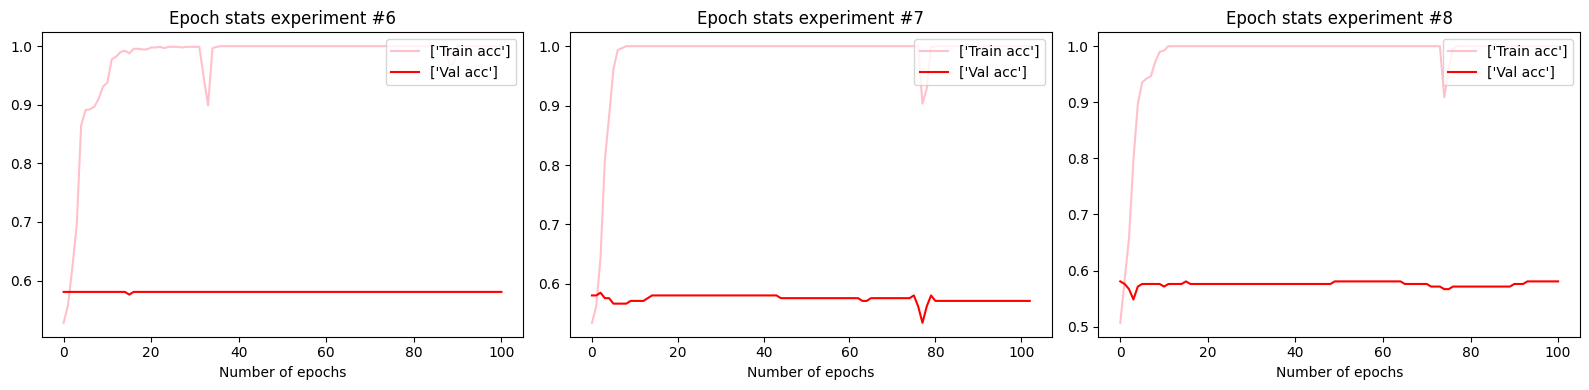

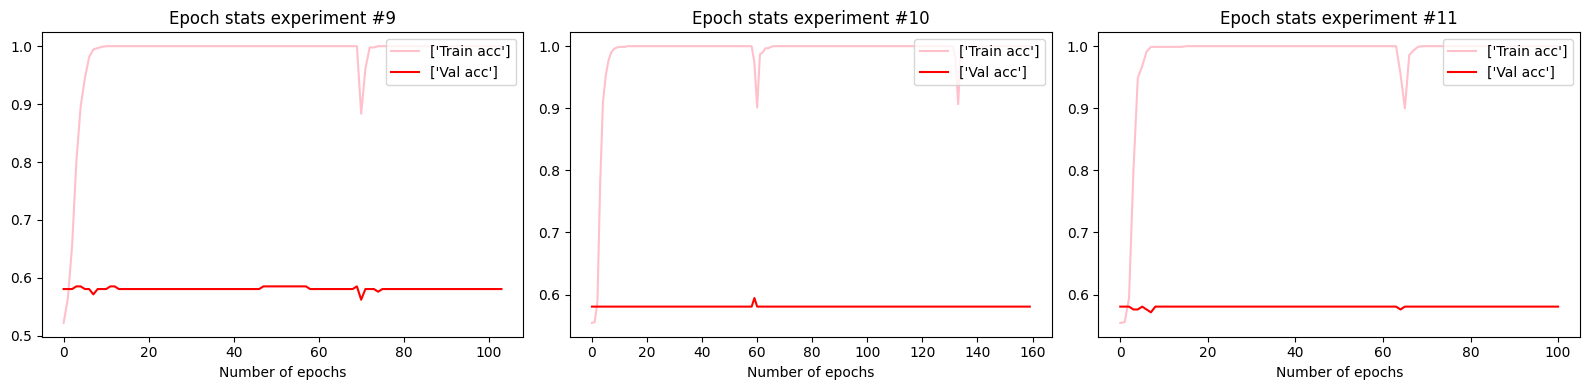

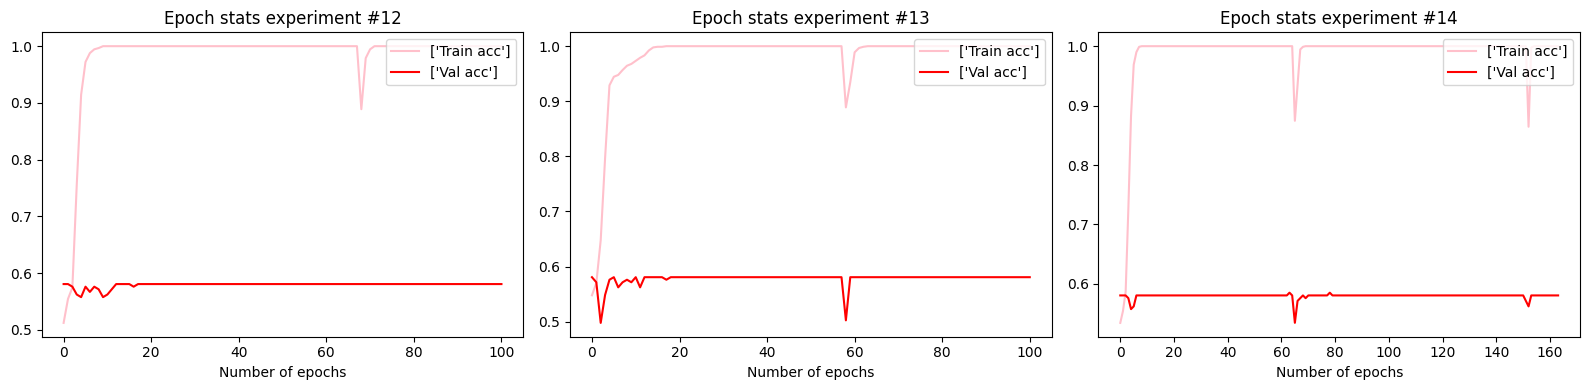

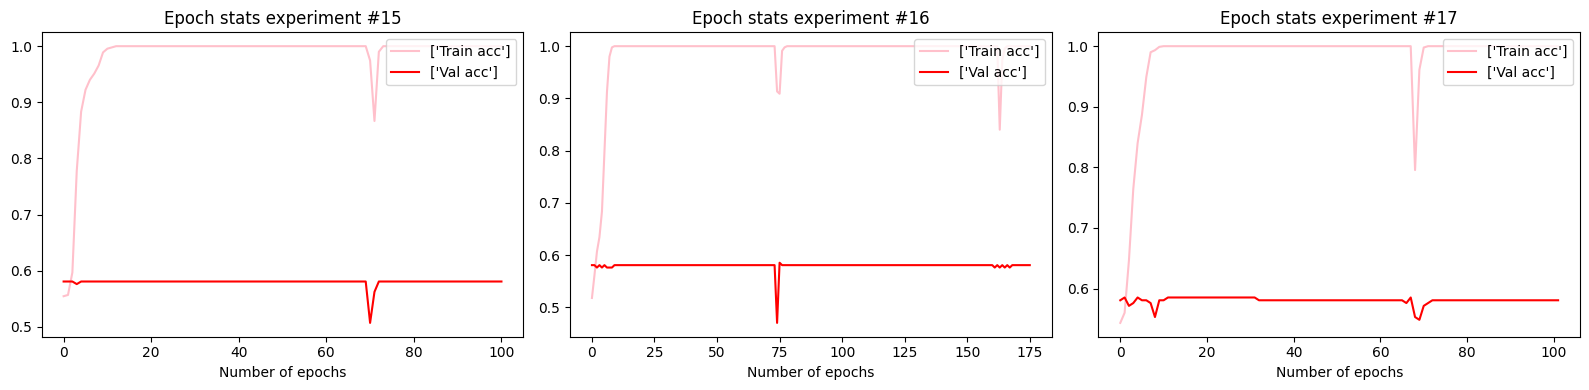

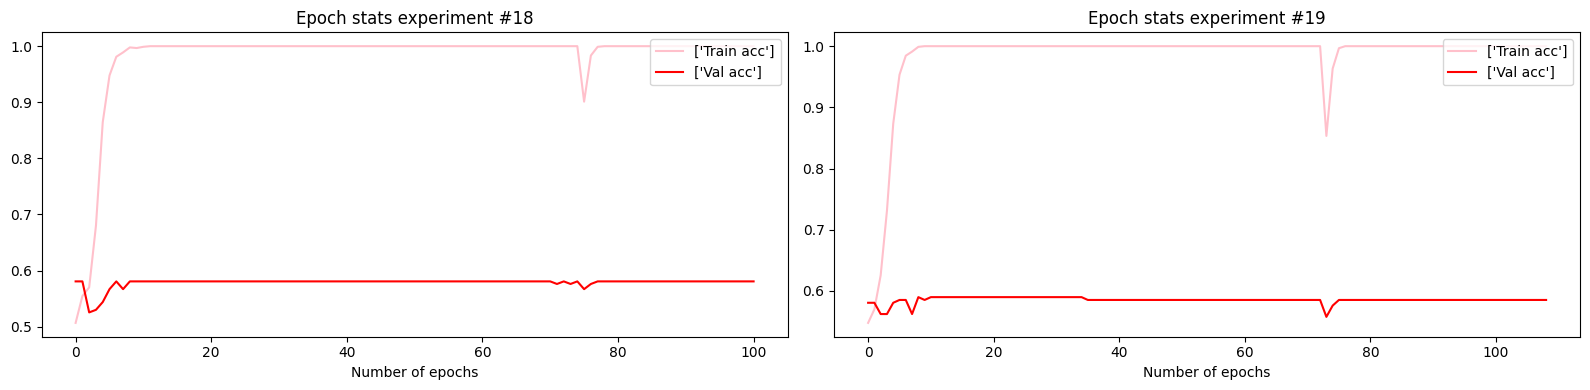

In [64]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [66]:
best_lstm_model = LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('./bestmodels/best_LSTM_model_' + experiment_name))
best_cnn_model = CNN_Model(data, 64, 128, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('./bestmodels/best_CNN_model_' + experiment_name))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('./bestmodels/best_DEEPSET_model_' + experiment_name))
best_deepsetv2_model = DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('./bestmodels/best_DEEPSETV2_model_' + experiment_name))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('./bestmodels/best_FEEDFORWARD_model_' + experiment_name))

C:\Users\franm\AppData\Local\Temp\ipykernel_22764\1326898690.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_lstm_model.load_state_dict(torch.load('./bestmodels/bes

<All keys matched successfully>

## Top wrong predictions for best performing CNN model

In [67]:
print_wrong_preds_bycases(get_wrong_predictions_bycases(best_cnn_model, x_test_cnn, y_test, test_original), k=10)

0 Atomicity violation cases wrong predicted:


0 DeadLock cases wrong predicted:


0 Data race cases wrong predicted:


0 Valid cases wrong predicted:




In [68]:
print_wrong_preds(get_wrong_predictions(best_cnn_model, x_test_cnn, y_test, test_original), k=10)

0 false Atomicity violation:


0 false DeadLock:


0 false Data race :


0 false Valid:




## Top wrong predictions for best performing LSTM model

In [69]:
print_wrong_preds_bycases(get_wrong_predictions_bycases(best_lstm_model, x_test_lstm, y_test, test_original), k=10)

0 Atomicity violation cases wrong predicted:


0 DeadLock cases wrong predicted:


10 Data race cases wrong predicted:
Sample ['._._.,_,.,__,._.', '___,...,_,_,wu._', '._....,,,__,.,r_', 'R'] | Prediction V
Sample [',___,.__..,,.__,', '_,.,.,__._,,.,_.', ',_.,_.,...,.__.r', 'R'] | Prediction V
Sample ['___,.____.,__,..', ',._.,,.,_,w.,,._', '..,,_....,,.,,,r', 'R'] | Prediction V
Sample ['_,,,__..____.,,_', '_..,,_,_,..,..__', '.,_..,_.._,,,..r', 'R'] | Prediction V
Sample ['...,...___,___,.', '....,,,_..,....w', '_..,_,_,..,,,_.r', 'R'] | Prediction V
Sample ['._.,__..._..,.,,', ',,,._,._wu..,.,,', '_,__,,.,.,_._.r_', 'R'] | Prediction V
Sample [',_._,__,.._,,__,', '.__.._..__wu..__', ',.,.._.._,,.,_r_', 'R'] | Prediction V
Sample [',,_,,._,,____,_,', ',__.._......w...', ',,._,.._..__._r,', 'R'] | Prediction V
Sample [',,,,____,,_..,,,', '_,__.,.,,,,wu.,_', '._._.,,_._,,.__r', 'R'] | Prediction V
Sample ['._,,._,,_.,,_,.,', ',_,_,,_,uw,,._,.', '_.._...,_.__,,r,', 'R'] | Prediction V



In [70]:
print_wrong_preds(get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original), k=10)

0 false Atomicity violation:


0 false DeadLock:


0 false Data race :


10 false Valid:
Sample ['._._.,_,.,__,._.', '___,...,_,_,wu._', '._....,,,__,.,r_', 'R'] | Prediction V
Sample [',___,.__..,,.__,', '_,.,.,__._,,.,_.', ',_.,_.,...,.__.r', 'R'] | Prediction V
Sample ['___,.____.,__,..', ',._.,,.,_,w.,,._', '..,,_....,,.,,,r', 'R'] | Prediction V
Sample ['_,,,__..____.,,_', '_..,,_,_,..,..__', '.,_..,_.._,,,..r', 'R'] | Prediction V
Sample ['...,...___,___,.', '....,,,_..,....w', '_..,_,_,..,,,_.r', 'R'] | Prediction V
Sample ['._.,__..._..,.,,', ',,,._,._wu..,.,,', '_,__,,.,.,_._.r_', 'R'] | Prediction V
Sample [',_._,__,.._,,__,', '.__.._..__wu..__', ',.,.._.._,,.,_r_', 'R'] | Prediction V
Sample [',,_,,._,,____,_,', ',__.._......w...', ',,._,.._..__._r,', 'R'] | Prediction V
Sample [',,,,____,,_..,,,', '_,__.,.,,,,wu.,_', '._._.,,_._,,.__r', 'R'] | Prediction V
Sample ['._,,._,,_.,,_,.,', ',_,_,,_,uw,,._,.', '_.._...,_.__,,r,', 'R'] | Prediction V




## Top wrong predictions for best performing DeepSets V1 model

In [71]:
print_wrong_preds_bycases(get_wrong_predictions_bycases(best_deepset_model, x_test_normal, y_test, test_original), k=10)

10 Atomicity violation cases wrong predicted:
Sample ['__.._.,_____...,', '...,,_._..uw....', ',.,,_..,dr,,_,,.', 'A'] | Prediction V
Sample ['.,,,__._,_,.._..', ',.,___.._,.,_uw.', ',._...,,__...dr_', 'A'] | Prediction V
Sample ['.___,_,,..,.,.__', '_,_..,,__uw.,_._', ',_.,____dr.__,.,', 'A'] | Prediction V
Sample ['.,,,.,___,____,.', '..__,.___,__,,uw', '_,,.___.,_.dr.,,', 'A'] | Prediction V
Sample ['...___,__,____,_', '.,__,__....uw.._', '.._.,.,.,_..dr..', 'A'] | Prediction V
Sample [',._._._,.,__,_._', '_._,...,_.uw.,._', '_,_._.__,.,_,_dr', 'A'] | Prediction V
Sample [',,,_..___.__.,_,', '__._____...___uw', '.,,,.__dr,..,,._', 'A'] | Prediction V
Sample [',_.,,._,,__,__..', '_,,_.,..,uw.___.', ',,.,,_,dr_,_,__.', 'A'] | Prediction V
Sample ['_,_.,._._,_..,._', ',.,,__...uw.._.,', '_.___,._.___,.dr', 'A'] | Prediction V
Sample ['.,.,_,.__..,,..,', ',.__,,._,_uw.,..', '.__,,,,_.dr_,,,,', 'A'] | Prediction V


10 DeadLock cases wrong predicted:
Sample ['____,.,.,,_..,_.', '_,_.,...

In [72]:
print_wrong_preds(get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original), k=10)

0 false Atomicity violation:


0 false DeadLock:


0 false Data race :


10 false Valid:
Sample ['____,.,.,,_..,_.', '_,_.,...,,w__,,_', '__,._.,__dr,__,.', 'D'] | Prediction V
Sample ['.,._.__,._.,....', '_..,,,.,,_.,w_..', ',,,.._.,dr,__,_,', 'D'] | Prediction V
Sample ['._.._,,_,,,_,_.,', ',,_,,__wu_,_.._.', '..._..,,r.,,.._,', 'R'] | Prediction V
Sample ['____.__,_,.,,.,,', ',,,_,,.__w,._...', '_.,_,.,_,__._dr,', 'D'] | Prediction V
Sample [',._.__.,,_....,_', '._.,___,__.,___,', '..,,,_.,.dr,,,..', 'D'] | Prediction V
Sample ['._._.,_,.,__,._.', '___,...,_,_,wu._', '._....,,,__,.,r_', 'R'] | Prediction V
Sample ['__.._.,_____...,', '...,,_._..uw....', ',.,,_..,dr,,_,,.', 'A'] | Prediction V
Sample [',.____,_.,._.,,_', '..__,.___w_..__,', ',...__.,,.dr_,,,', 'D'] | Prediction V
Sample [',_,,,__,__.,__,,', '.,,,..,...w,._,,', '_._....,_,_r__,_', 'R'] | Prediction V
Sample ['.,,,__._,_,.._..', ',.,___.._,.,_uw.', ',._...,,__...dr_', 'A'] | Prediction V




## Top wrong predictions for best performing DeepSets V2 model

In [73]:
print_wrong_preds_bycases(get_wrong_predictions_bycases(best_deepsetv2_model, x_test_normal, y_test, test_original), k=10)

10 Atomicity violation cases wrong predicted:
Sample ['__.._.,_____...,', '...,,_._..uw....', ',.,,_..,dr,,_,,.', 'A'] | Prediction V
Sample ['.,,,__._,_,.._..', ',.,___.._,.,_uw.', ',._...,,__...dr_', 'A'] | Prediction V
Sample ['.___,_,,..,.,.__', '_,_..,,__uw.,_._', ',_.,____dr.__,.,', 'A'] | Prediction V
Sample ['.,,,.,___,____,.', '..__,.___,__,,uw', '_,,.___.,_.dr.,,', 'A'] | Prediction V
Sample ['...___,__,____,_', '.,__,__....uw.._', '.._.,.,.,_..dr..', 'A'] | Prediction V
Sample [',._._._,.,__,_._', '_._,...,_.uw.,._', '_,_._.__,.,_,_dr', 'A'] | Prediction V
Sample [',,,_..___.__.,_,', '__._____...___uw', '.,,,.__dr,..,,._', 'A'] | Prediction V
Sample [',_.,,._,,__,__..', '_,,_.,..,uw.___.', ',,.,,_,dr_,_,__.', 'A'] | Prediction V
Sample ['_,_.,._._,_..,._', ',.,,__...uw.._.,', '_.___,._.___,.dr', 'A'] | Prediction V
Sample ['.,.,_,.__..,,..,', ',.__,,._,_uw.,..', '.__,,,,_.dr_,,,,', 'A'] | Prediction V


10 DeadLock cases wrong predicted:
Sample ['____,.,.,,_..,_.', '_,_.,...

In [74]:
print_wrong_preds(get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original), k=10)

2 false Atomicity violation:
Sample ['.,__,,..,__.,,_,', ',._.._,__,uw,_,,', ',,__,__,,,.r___.', 'R'] | Prediction A
Sample [',._,___,..,,.,,_', '_.,__,_wu___,_.,', ',,__.__..,,r_.__', 'R'] | Prediction A


0 false DeadLock:


0 false Data race :


10 false Valid:
Sample ['____,.,.,,_..,_.', '_,_.,...,,w__,,_', '__,._.,__dr,__,.', 'D'] | Prediction V
Sample ['.,._.__,._.,....', '_..,,,.,,_.,w_..', ',,,.._.,dr,__,_,', 'D'] | Prediction V
Sample ['._.._,,_,,,_,_.,', ',,_,,__wu_,_.._.', '..._..,,r.,,.._,', 'R'] | Prediction V
Sample ['____.__,_,.,,.,,', ',,,_,,.__w,._...', '_.,_,.,_,__._dr,', 'D'] | Prediction V
Sample [',._.__.,,_....,_', '._.,___,__.,___,', '..,,,_.,.dr,,,..', 'D'] | Prediction V
Sample ['._._.,_,.,__,._.', '___,...,_,_,wu._', '._....,,,__,.,r_', 'R'] | Prediction V
Sample ['__.._.,_____...,', '...,,_._..uw....', ',.,,_..,dr,,_,,.', 'A'] | Prediction V
Sample [',.____,_.,._.,,_', '..__,.___w_..__,', ',...__.,,.dr_,,,', 'D'] | Prediction V
Sample [',_,,,__,__.,__,,', '.,

## Top wrong predictions for best performing Feedforward model

In [75]:
print_wrong_preds_bycases(get_wrong_predictions_bycases(best_feedforward_model, x_test_normal, y_test, test_original), k=10)

10 Atomicity violation cases wrong predicted:
Sample ['__.._.,_____...,', '...,,_._..uw....', ',.,,_..,dr,,_,,.', 'A'] | Prediction V
Sample ['.,,,__._,_,.._..', ',.,___.._,.,_uw.', ',._...,,__...dr_', 'A'] | Prediction V
Sample ['.___,_,,..,.,.__', '_,_..,,__uw.,_._', ',_.,____dr.__,.,', 'A'] | Prediction V
Sample ['.,,,.,___,____,.', '..__,.___,__,,uw', '_,,.___.,_.dr.,,', 'A'] | Prediction V
Sample ['...___,__,____,_', '.,__,__....uw.._', '.._.,.,.,_..dr..', 'A'] | Prediction V
Sample [',._._._,.,__,_._', '_._,...,_.uw.,._', '_,_._.__,.,_,_dr', 'A'] | Prediction V
Sample [',,,_..___.__.,_,', '__._____...___uw', '.,,,.__dr,..,,._', 'A'] | Prediction V
Sample [',_.,,._,,__,__..', '_,,_.,..,uw.___.', ',,.,,_,dr_,_,__.', 'A'] | Prediction V
Sample ['_,_.,._._,_..,._', ',.,,__...uw.._.,', '_.___,._.___,.dr', 'A'] | Prediction V
Sample ['.,.,_,.__..,,..,', ',.__,,._,_uw.,..', '.__,,,,_.dr_,,,,', 'A'] | Prediction V


10 DeadLock cases wrong predicted:
Sample ['____,.,.,,_..,_.', '_,_.,...

In [76]:
print_wrong_preds(get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original), k=10)

0 false Atomicity violation:


0 false DeadLock:


0 false Data race :


10 false Valid:
Sample ['____,.,.,,_..,_.', '_,_.,...,,w__,,_', '__,._.,__dr,__,.', 'D'] | Prediction V
Sample ['.,._.__,._.,....', '_..,,,.,,_.,w_..', ',,,.._.,dr,__,_,', 'D'] | Prediction V
Sample ['._.._,,_,,,_,_.,', ',,_,,__wu_,_.._.', '..._..,,r.,,.._,', 'R'] | Prediction V
Sample ['____.__,_,.,,.,,', ',,,_,,.__w,._...', '_.,_,.,_,__._dr,', 'D'] | Prediction V
Sample [',._.__.,,_....,_', '._.,___,__.,___,', '..,,,_.,.dr,,,..', 'D'] | Prediction V
Sample ['._._.,_,.,__,._.', '___,...,_,_,wu._', '._....,,,__,.,r_', 'R'] | Prediction V
Sample ['__.._.,_____...,', '...,,_._..uw....', ',.,,_..,dr,,_,,.', 'A'] | Prediction V
Sample [',.____,_.,._.,,_', '..__,.___w_..__,', ',...__.,,.dr_,,,', 'D'] | Prediction V
Sample [',_,,,__,__.,__,,', '.,,,..,...w,._,,', '_._....,_,_r__,_', 'R'] | Prediction V
Sample ['.,,,__._,_,.._..', ',.,___.._,.,_uw.', ',._...,,__...dr_', 'A'] | Prediction V




# Saving Notebook State

In [80]:
import dill
dill.dump_session('notebook_env_first_half.db')

# Loading Notebook State

In [81]:
import dill
# dill.load_session('notebook_env_first_half.db')